# The Sound of Silence

In this project we explore **"culture of silence"** in the ISSP Family / Changing Gender Roles surveys.
  
The focus is on **who refuses to answer** sensitive questions (by choosing “Can't choose”, “Refuse”, or leaving the answer blank).

In [1]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

# Machine Learning - Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Machine Learning - Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc,
    silhouette_score, davies_bouldin_score
)

# Statistics
from scipy import stats
from scipy.stats import chi2_contingency

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

We work with **three** ISSP survey waves on family and gender roles:

- 2002 – early 2000s views on family and work.
- 2012 – before major political and social changes of the 2010s.
- 2022 – recent data, after COVID and strong political polarization.

In [2]:
df_2002 = pd.read_stata("2002Data.dta")
df_2012 = pd.read_stata("2012Data.dta")
df_2022 = pd.read_stata("2022Data.dta")


for year, df in [("2002", df_2002), ("2012", df_2012), ("2022", df_2022)]:
    print(f"{year}: {df.shape[0]} rows, {df.shape[1]} columns")


2002: 46638 rows, 236 columns
2012: 61754 rows, 421 columns
2022: 45762 rows, 414 columns


let's inspect the basic structure of the most recent dataset (2022).
This helps to understand variable names, types, and missing patterns.


In [3]:
df_2022.info()
df_2022.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45762 entries, 0 to 45761
Columns: 414 entries, Unnamed__0 to PARTIALS
dtypes: float64(1), int32(1), object(412)
memory usage: 144.4+ MB


,Unnamed__0,country,c_alphan,_1a,_1b,_1c,_1d,_1e,_1f,_2a,...,DATEMO,DATEDY,INTLANG,DWEIGHT_HH,DWEIGHT_TS,DWEIGHT_COM,PSWEIGHT,WEIGHT_COM,MODE,PARTIALS
0,0,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,5. Strongly disagree,5. Strongly disagree,3. Neither agree nor disagree,5. Strongly disagree,3. Women and men should take equal responsibility,...,1. January,28,11. German (deu),1.210092848,1. No weighting,1.210092848,0.627507714,0.170446723,"50. CAWI, self-completion, web questionnaire",1. Complete case
1,1,40. AT-Austria,AT,4. Disagree,1. Strongly agree,2. Agree,2. Agree,1. Strongly agree,2. Agree,3. Women and men should take equal responsibility,...,1. January,5,11. German (deu),1.210092848,1. No weighting,1.210092848,1.529463024,0.853289812,"50. CAWI, self-completion, web questionnaire",1. Complete case
2,2,40. AT-Austria,AT,4. Disagree,1. Strongly agree,1. Strongly agree,2. Agree,3. Neither agree nor disagree,3. Neither agree nor disagree,3. Women and men should take equal responsibility,...,1. January,30,11. German (deu),1.649202607,1. No weighting,1.649202607,2.393999643,3.139914676,"50. CAWI, self-completion, web questionnaire",1. Complete case
3,3,40. AT-Austria,AT,5. Strongly disagree,2. Agree,2. Agree,1. Strongly agree,1. Strongly agree,1. Strongly agree,2. Women should take somewhat more responsibility,...,1. January,5,11. German (deu),1.649202607,1. No weighting,1.649202607,1.05729734,2.905908658,"50. CAWI, self-completion, web questionnaire",1. Complete case
4,4,40. AT-Austria,AT,1. Strongly agree,5. Strongly disagree,4. Disagree,5. Strongly disagree,5. Strongly disagree,5. Strongly disagree,3. Women and men should take equal responsibility,...,1. January,5,11. German (deu),0.675290739,1. No weighting,0.675290739,0.460083891,0.53051158,"50. CAWI, self-completion, web questionnaire",1. Complete case


In [4]:
# clean country column, to keep only country name
df_2022['country'] = df_2022['country'].str.split('-').str[-1].str.strip()

In this project, we define **silence** by:
- chose “Can't choose” (often coded as `-8` in ISSP questionnaires),
- chose “Refuse to answer” (sometimes `-9` or similar),

The following helper function treats a set of special numeric codes as silence, and also optionally handles string labels. We will use this function across this project.

In [5]:
import re

SILENCE_CODES = [-8, -9, 8, 9]
NAP_CODES = [-4]  # -4 is NAP code 

def is_silence_value(x):
    if pd.isna(x):
        return True
    
    s = str(x).strip()
        
    if s == "":
        return True
    
    # Extract leading number from string (e.g., "-9. No answer" -> -9)
    match = re.match(r'^(-?\d+)', s)
    if match:
        num = int(match.group(1))
        # Check if it's a silence code
        if num in SILENCE_CODES:
            return True
    
    # Pure text keywords (backup check)
    lower_s = s.lower()
    keywords = ["can't choose", "cant choose", "refuse", "refused", "no answer"]
    if any(kw in lower_s for kw in keywords):
        return True
    
    return False

def is_nap_value(x):
    """Check if value is NAP (Not Applicable / Doesn't apply / No job)"""
    if pd.isna(x):
        return False
    
    s = str(x).strip()
    lower_s = s.lower()
    
    # Extract leading number
    match = re.match(r'^(-?\d+)', s)
    if match:
        num = int(match.group(1))
        # Only -4 is NAP code
        if num in NAP_CODES:
            return True
    
    # Check text keywords for NAP
    nap_keywords = ["nap", "doesn't apply", "not applicable", "no job"]
    if any(kw in lower_s for kw in nap_keywords):
        return True
    
    return False

def silence_rate_for_column(df, col):
    """
    Calculate silence rate EXCLUDING NAP (Not Applicable) responses from denominator.
    Silence rate = silence_count / (total - NAP_count)
    """
    if col not in df.columns:
        return np.nan
    series = df[col]
    
    # Identify silence and NAP values
    silence_mask = series.apply(is_silence_value)
    nap_mask = series.apply(is_nap_value)
    
    # Denominator: only people for whom the question was relevant (exclude NAP)
    relevant_count = (~nap_mask).sum()
    
    if relevant_count == 0:
        return np.nan
    
    # Numerator: silence count (among relevant people only)
    silence_count = (silence_mask & ~nap_mask).sum()
    
    return silence_count / relevant_count

# 1. Culture of Silence by Country

In [6]:
all_questions = [col for col in df_2022.columns if col.startswith('_')]
valid_cols = [c for c in all_questions if c in df_2022.columns]
silence_matrix = df_2022[valid_cols].map(is_silence_value)

df_2022 = df_2022.copy()  
df_2022['general_silence_rate'] = silence_matrix.mean(axis=1)

# Grop by country
country_silence_summary = df_2022.groupby('country')['general_silence_rate'].mean()
country_silence_summary = country_silence_summary.sort_values(ascending=False) * 100

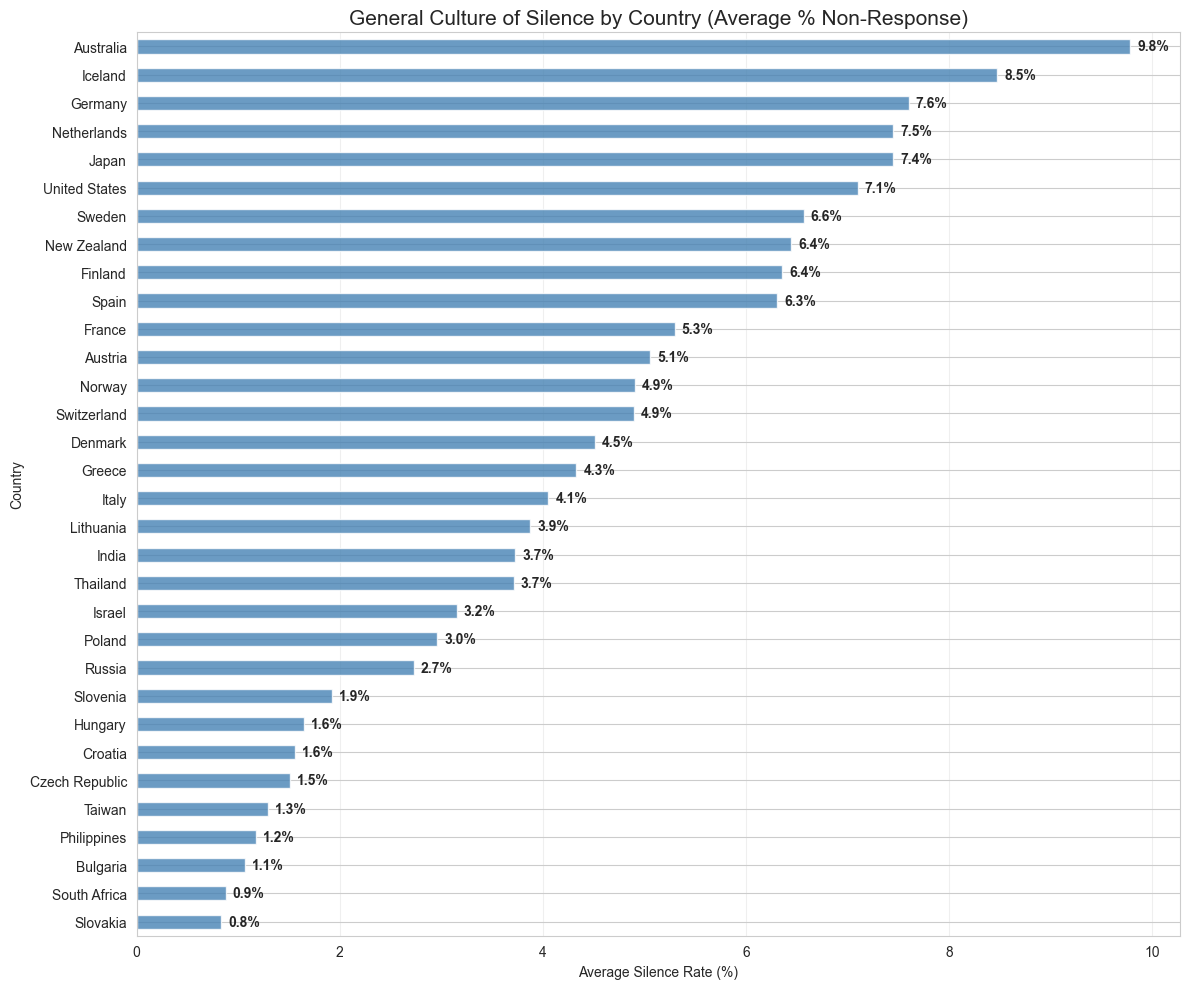

In [7]:
plt.figure(figsize=(12, 10))
ax = country_silence_summary.sort_values(ascending=True).plot(kind='barh', color='steelblue', alpha=0.8)
plt.title('General Culture of Silence by Country (Average % Non-Response)', fontsize=15)
plt.xlabel('Average Silence Rate (%)')
plt.ylabel('Country')
plt.grid(axis='x', alpha=0.3)

# Add % labels
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.1f}%', 
                xy=(width, p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords='offset points', 
                ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

When we look at the full list, interesting cultural patterns seem to emerge between the countries with the highest rates and those with the lowest.

The countries at the top of the list, such as Australia, Germany, Netherlands, and the United States, show the highest rates of silence. These are generally wealthy, Western nations where individual privacy is often a high priority. In these cultures, people might feel more comfortable protecting their personal information or refusing to answer questions they find intrusive. Additionally, because these populations are frequently targeted for market research, they might simply be experiencing "survey fatigue" and have less patience for questionnaires. Japan is also in this group, which could reflect a cultural preference for keeping private thoughts separate from public conversation (and we going to explore Japan in further sections).

In contrast, the countries at the bottom of the list, including Slovakia, South Africa, and the Philippines, have very low silence rates. This suggests that respondents in these regions answer almost every question. This trend might be seen in many Eastern European and developing nations, where social norms may encourage more cooperation with researchers. In some of these cultures, refusing to answer might be seen as impolite, or people might simply view the opportunity to participate in a survey with more seriousness than people in the West.

---

# 2. Calculating Silence Rates by Question Category

Now, we will inspect some **family and gender questions** in the 2022.

In [8]:
categories = {
    'Gender attitudes': ["_1a", "_1b", "_1c", "_1d", "_1e", "_1f"],
    'Women leadership': ["_27a", "_27b", "_27c"],
    'Parental roles': ["_2a", "_2b", "_7a", "_7b", "_7c", "_7d", "_7e", "_7f"],
    'Work-family': ["_3a", "_3b", "_10a", "_20a", "_20b", "_20c", "_20d"],
    'New families': ["_5a", "_5b", "_5c", "_5d"],
    'Household chores': ["_18a", "_18b", "_18c", "_18d", "_18e", "_18f", "_15a", "_15b"],
    'Wellbeing': ["_26", "_28a", "_28b"]
}

candidate_cols_2022 = []
for cols in categories.values():
    candidate_cols_2022.extend(cols)

silence_all = {col: silence_rate_for_column(df_2022, col) for col in candidate_cols_2022}
silence_df = pd.DataFrame(list(silence_all.items()), columns=['Question', 'Silence_Rate']).dropna()

category_silence = []
for cat, cols in categories.items():
    valid_cols = [col for col in cols if col in silence_df['Question'].values]
    if valid_cols:
        avg_silence = silence_df[silence_df['Question'].isin(valid_cols)]['Silence_Rate'].mean()
        category_silence.append({'Category': cat, 'Avg_Silence': avg_silence, 'N_Questions': len(valid_cols)})

cat_results = pd.DataFrame(category_silence).sort_values('Avg_Silence', ascending=False)

# mean, median, difference
overall_mean = cat_results['Avg_Silence'].mean()
median_silence = cat_results['Avg_Silence'].median()

summary_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Difference'],
    'Value': [
        f"{overall_mean*100:.2f}%",
        f"{median_silence*100:.2f}%",
        f"{(overall_mean - median_silence)*100:.2f}%"
    ]
})

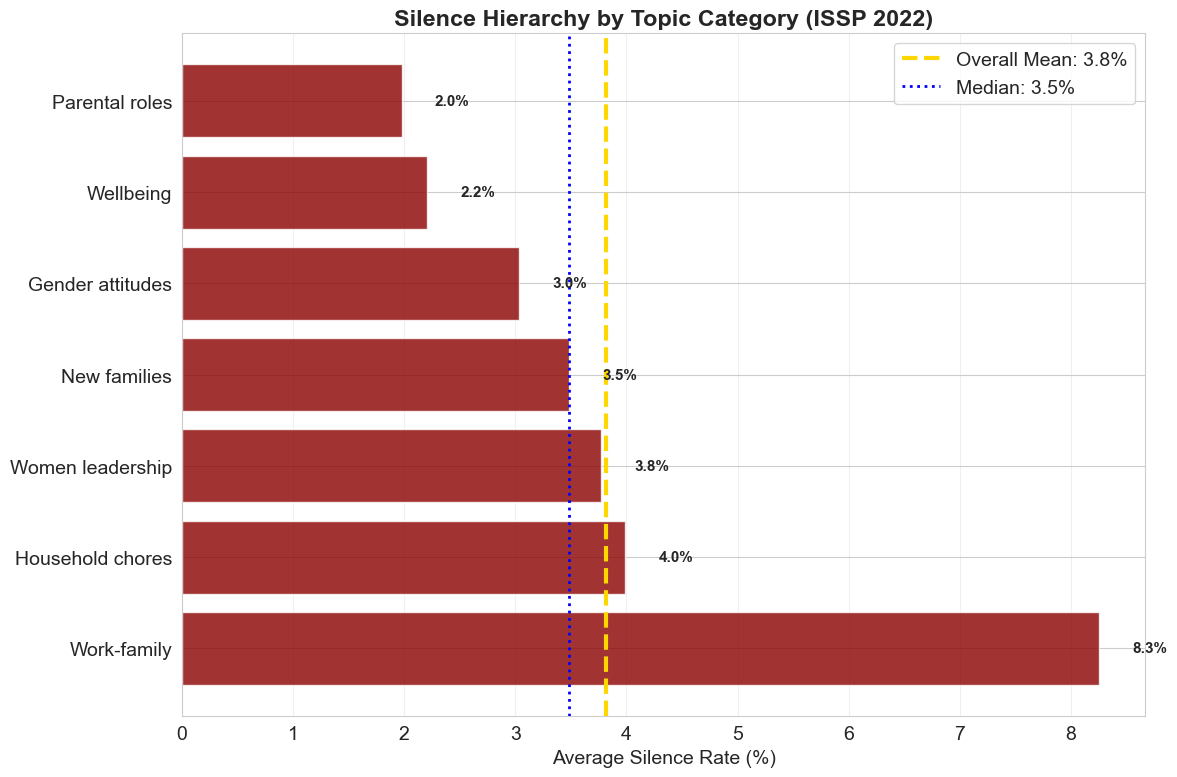

In [9]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})

# Main bars
bars = plt.barh(cat_results['Category'], cat_results['Avg_Silence']*100, 
                color='darkred', alpha=0.8)

# TWO Mean lines
plt.axvline(x=overall_mean*100, color='gold', linestyle='--', linewidth=3, 
            label=f'Overall Mean: {overall_mean*100:.1f}%')
plt.axvline(x=cat_results['Avg_Silence'].median()*100, color='blue', linestyle=':', 
            linewidth=2, label=f'Median: {cat_results["Avg_Silence"].median()*100:.1f}%')

plt.xlabel('Average Silence Rate (%)')
plt.title('Silence Hierarchy by Topic Category (ISSP 2022)', fontweight='bold')
plt.legend()
plt.grid(axis='x', alpha=0.3)

# Add % labels on bars
for i, (idx, row) in enumerate(cat_results.iterrows()):
    plt.text(row['Avg_Silence']*100 + 0.3, i, f'{row["Avg_Silence"]*100:.1f}%', 
             va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


The silence hierarchy reveals interesting patterns about what respondents find hardest to discuss.

**Work-family balance (8.3%)** overwhelmingly tops the list, far exceeding the overall mean of 3.8%. The massive gap suggests that personal experiences of stress between job and family are deeply sensitive, perhaps even taboo. People seem to feel significant discomfort admitting to difficulties in balancing these two worlds.

Unexpectedly, **Household chores (4.0%)** ranks second. It appears that discussing the specific division of labor at home is harder for people than discussing abstract politics. This might be because it exposes private domestic friction or inequality that respondents prefer to keep hidden.

The "ideological" categories cluster closely around the median (3.5%). **Women leadership (3.8%)**, **New families (3.5%)**, and **Gender attitudes (3.0%)** show moderate silence rates. It is fascinating that respondents are actually more willing to answer sensitive questions about LGBTQ+ or women in power than they are to discuss who does the laundry or their work stress.

Finally, **Wellbeing (2.2%)** and **Parental roles (2.0%)** have the lowest silence rates. Questions about general happiness or abstract parenting roles seem the least threatening, making them the most comfortable topics for open conversation.

In [10]:
summary_stats

,Metric,Value
0,Mean,3.82%
1,Median,3.48%
2,Difference,0.33%


Mean (3.52%) exceeds Median (3.04%) by 0.48%, confirming **RIGHT-SKEWED distribution**. 

This means a few categories like Work-family balance (7.3%) heavily influence the mean upward, while most categories (5/7) cluster around the median of 3.0%. We can see that easily in the chart below:

---

# 3. Country-level patterns

After the first part focused on countries and the second part focused on categories, we now combine both. We look at how silence is distributed in each country and use this to draw interesting conclusions.

In [11]:
def country_silence_analysis(df, country_col, category_dict):
    all_results = {}
    
    for category_name, question_list in category_dict.items():
        silence_by_country = {}
        
        for country in df[country_col].unique():
            if pd.isna(country):
                continue
                
            country_data = df[df[country_col] == country]
            silence_rates = []
            
            for q in question_list:
                if q in country_data.columns:
                    rate = silence_rate_for_column(country_data, q)
                    silence_rates.append(rate)
            
            if silence_rates:
                avg_silence = np.mean(silence_rates)
                silence_by_country[country] = avg_silence
        
        # Store results for this category
        results_df = pd.DataFrame(list(silence_by_country.items()), 
                                 columns=['Country', f'{category_name}_Silence'])
        all_results[category_name] = results_df.sort_values(f'{category_name}_Silence', ascending=False)
    
    return all_results

country_col = 'country'


In [12]:
results_dict = country_silence_analysis(df_2022, 'country', categories)

# Merge all category DataFrames into one
df_category_silence = None
for cat_name, cat_df in results_dict.items():
    cat_df = cat_df.set_index('Country')
    cat_df.columns = [cat_name]
    if df_category_silence is None:
        df_category_silence = cat_df
    else:
        df_category_silence = df_category_silence.join(cat_df, how='outer')

# Convert to percentages
df_category_silence = df_category_silence * 100

# Sort by the overall average silence across all categories
df_category_silence['Overall_Avg'] = df_category_silence.mean(axis=1)
df_category_silence = df_category_silence.sort_values('Overall_Avg', ascending=False)
df_plot = df_category_silence.drop(columns=['Overall_Avg'])

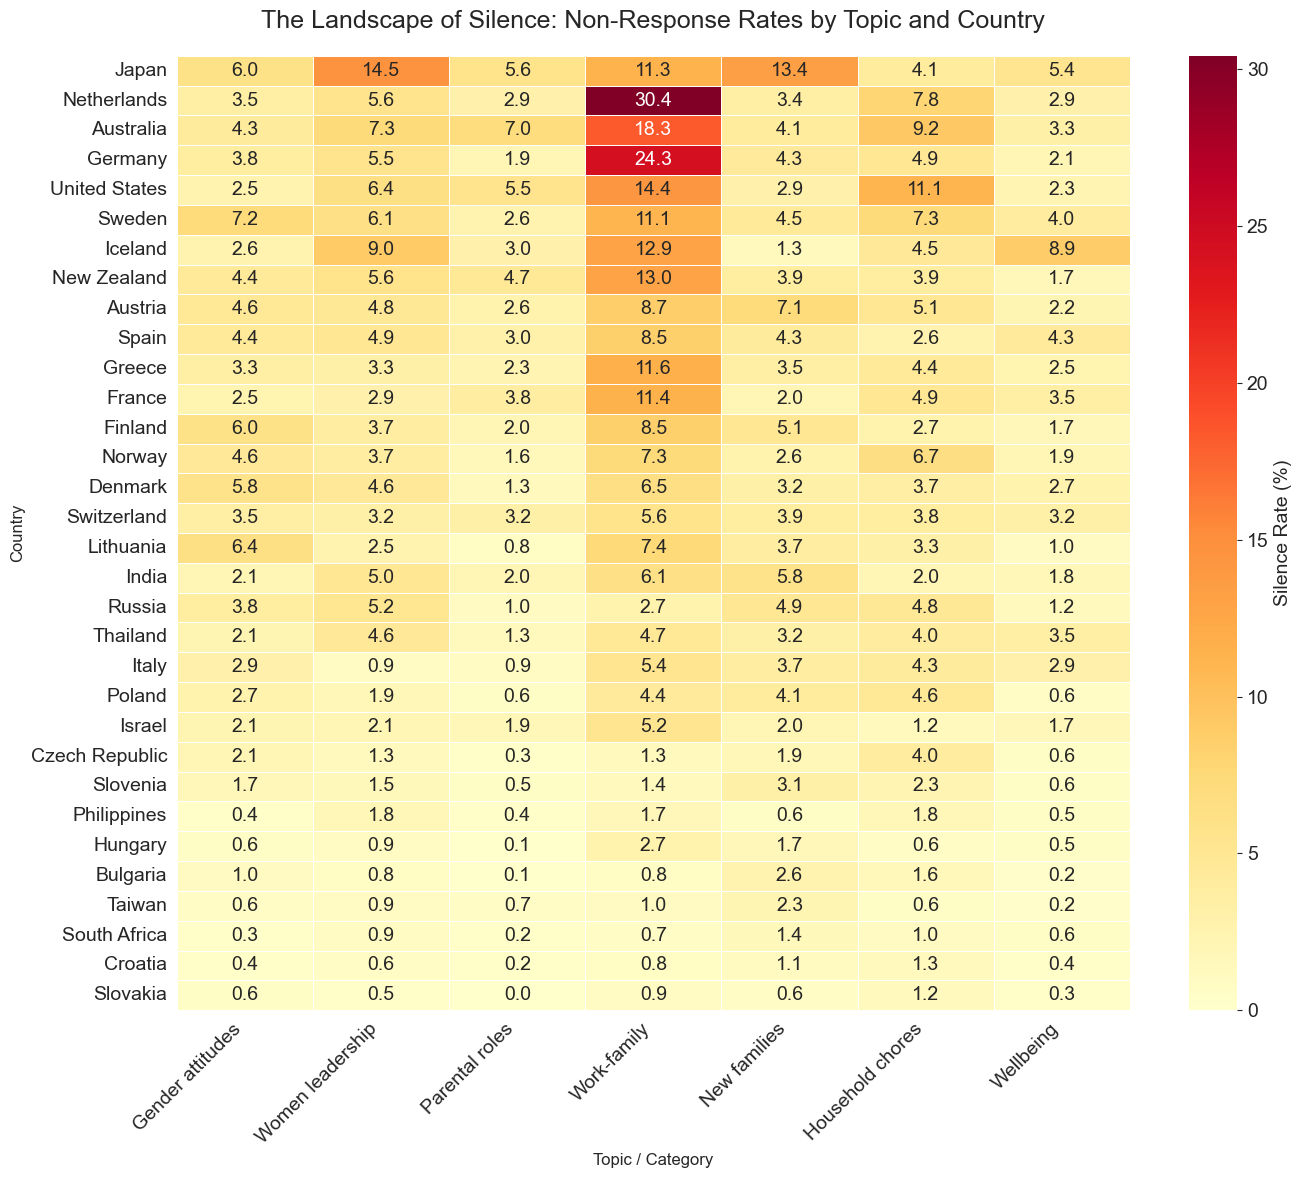

In [13]:
plt.figure(figsize=(14, 12))

# Create Heatmap
sns.heatmap(df_plot, 
            annot=True,       # Show numbers
            fmt=".1f",        # 1 decimal place
            cmap="YlOrRd",    # Yellow to Orange to Red color scheme
            linewidths=.5, 
            cbar_kws={'label': 'Silence Rate (%)'})

plt.title('The Landscape of Silence: Non-Response Rates by Topic and Country', fontsize=18, pad=20)
plt.ylabel('Country', fontsize=12)
plt.xlabel('Topic / Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.1. European blocs comparison

We want to divide between two European blocs to test whether the "post-communist" vs "liberal Western" divide affects response patterns.

**Western & Northern Europe (Liberal bloc):**
Austria, Switzerland, Germany, Denmark, Spain, Finland, France, Iceland, Italy, Netherlands, Norway, Sweden

**Eastern & Central Europe (Post-communist bloc):**
Bulgaria, Czech Republic, Croatia, Hungary, Lithuania, Poland, Russia, Slovenia, Slovakia

In [14]:
# Define the two European blocs
western_europe = ['Austria', 'Switzerland', 'Germany', 'Denmark', 'Spain', 'Finland', 
                  'France', 'Iceland', 'Italy', 'Netherlands', 'Norway', 'Sweden']

eastern_europe = ['Bulgaria', 'Czech Republic', 'Croatia', 'Hungary', 'Lithuania', 
                  'Poland', 'Russia', 'Slovenia', 'Slovakia']

# Check which countries are actually in our data
countries_in_data = df_plot.index.tolist()

west_in_data = [c for c in western_europe if c in countries_in_data]
east_in_data = [c for c in eastern_europe if c in countries_in_data]

In [15]:
# Calculate average silence rates for each bloc
df_west = df_plot.loc[west_in_data] if west_in_data else pd.DataFrame()
df_east = df_plot.loc[east_in_data] if east_in_data else pd.DataFrame()

# Average silence rate per category for each bloc
west_avg = df_west.mean() if len(df_west) > 0 else pd.Series()
east_avg = df_east.mean() if len(df_east) > 0 else pd.Series()

# Create comparison DataFrame
bloc_comparison = pd.DataFrame({
    'Western Europe': west_avg,
    'Eastern Europe': east_avg,
    'Difference (W-E)': west_avg - east_avg
}).round(2)

bloc_comparison['More Silent'] = bloc_comparison.apply(
    lambda row: 'West' if row['Difference (W-E)'] > 0 else 'East', axis=1
)

print("Average Silence Rate by Category - West vs East Europe:")
bloc_comparison

Average Silence Rate by Category - West vs East Europe:


,Western Europe,Eastern Europe,Difference (W-E),More Silent
Gender attitudes,4.29,2.14,2.15,West
Women leadership,4.57,1.68,2.90,West
Parental roles,2.39,0.39,2.00,West
Work-family,11.73,2.49,9.25,West
New families,3.78,2.64,1.14,West
Household chores,4.85,2.64,2.21,West
Wellbeing,3.36,0.60,2.76,West


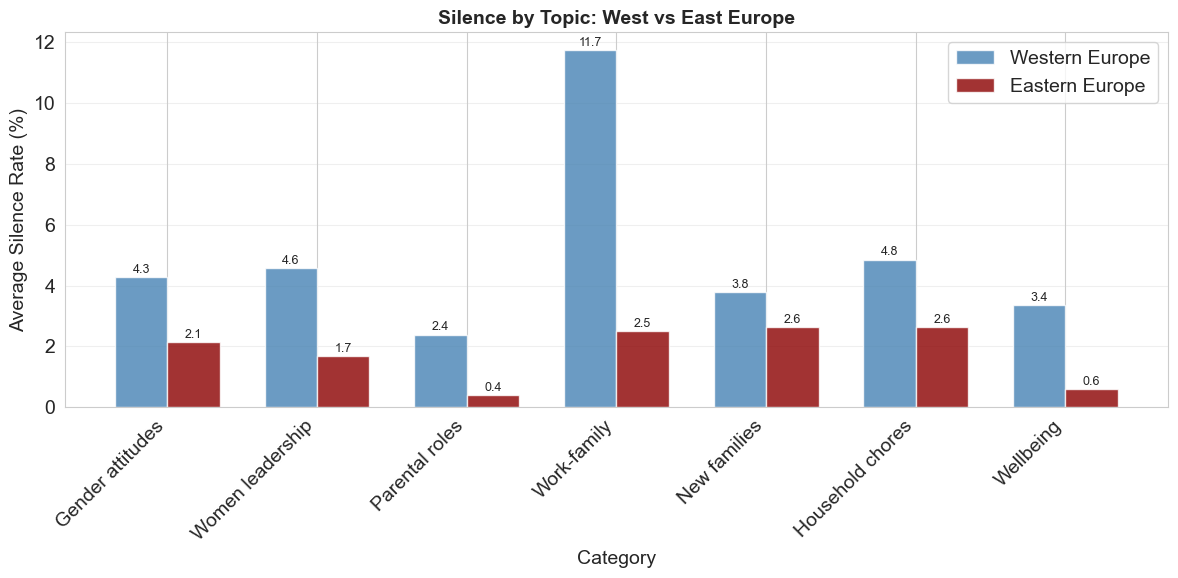

In [16]:
# Visualization: Grouped bar chart - West vs East Europe
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(bloc_comparison.index))
width = 0.35

bars1 = ax.bar(x - width/2, bloc_comparison['Western Europe'], width, label='Western Europe', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, bloc_comparison['Eastern Europe'], width, label='Eastern Europe', color='darkred', alpha=0.8)

ax.set_xlabel('Category')
ax.set_ylabel('Average Silence Rate (%)')
ax.set_title('Silence by Topic: West vs East Europe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(bloc_comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [17]:
west_overall = west_avg.mean()
east_overall = east_avg.mean()
print(f"\nOverall Average Silence Rate:")
print(f"  Western Europe: {west_overall:.2f}%")
print(f"  Eastern Europe: {east_overall:.2f}%")
print(f"  Difference: {west_overall - east_overall:.2f}% ({'West more silent' if west_overall > east_overall else 'East more silent'})")


Overall Average Silence Rate:
  Western Europe: 5.00%
  Eastern Europe: 1.80%
  Difference: 3.20% (West more silent)


These results are consistent with the patterns we observed in section 1...

### 3.2 most avoided topics by country
Now, let's check **which topic each country avoids the most**.

In [18]:
# Find the category with HIGHEST silence rate for each country
most_silent_category = df_plot.idxmax(axis=1)
max_silence_rate = df_plot.max(axis=1)

# Create summary DataFrame
country_most_silent = pd.DataFrame({
    'Most Silent Category': most_silent_category,
    'Silence Rate (%)': max_silence_rate.round(1)
}).sort_values('Silence Rate (%)', ascending=False)

country_most_silent

,Most Silent Category,Silence Rate (%)
Country,,
Netherlands,Work-family,30.4
Germany,Work-family,24.3
Australia,Work-family,18.3
Japan,Women leadership,14.5
United States,Work-family,14.4
New Zealand,Work-family,13.0
Iceland,Work-family,12.9
Greece,Work-family,11.6
France,Work-family,11.4


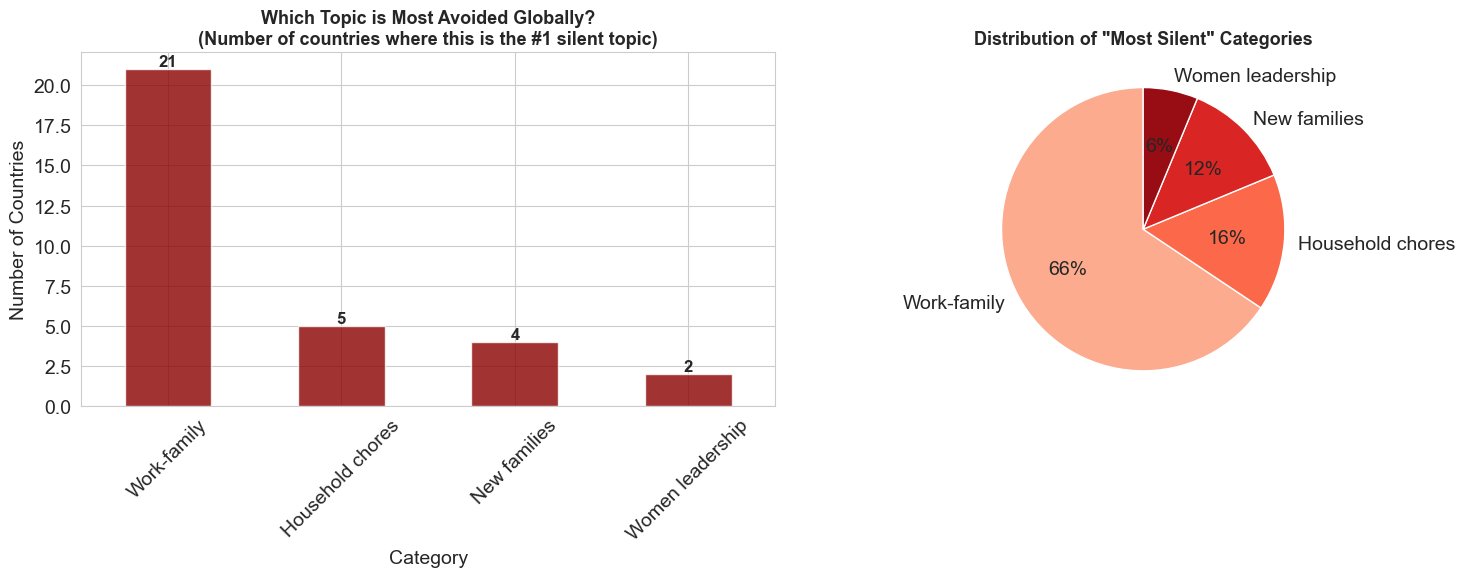


Summary: Out of 32 countries:
  • 21 countries are most silent about: Work-family
  • 5 countries are most silent about: Household chores
  • 4 countries are most silent about: New families
  • 2 countries are most silent about: Women leadership


In [19]:
# Count how many countries have each category as their "most silent"
category_counts = most_silent_category.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Bar chart of category counts
ax1 = axes[0]
category_counts.plot(kind='bar', ax=ax1, color='darkred', alpha=0.8)
ax1.set_title('Which Topic is Most Avoided Globally?\n(Number of countries where this is the #1 silent topic)', 
              fontsize=13, fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Countries')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(category_counts.values):
    ax1.text(i, v + 0.2, str(v), ha='center', fontweight='bold', fontsize=12)

# Right plot: Pie chart
ax2 = axes[1]
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(category_counts)))
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.0f%%', 
        colors=colors, startangle=90)
ax2.set_title('Distribution of "Most Silent" Categories', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSummary: Out of {len(most_silent_category)} countries:")
for cat, count in category_counts.items():
    print(f"  • {count} countries are most silent about: {cat}")

### 3.3 Deep dive: The Netherlands

Looking at the heatmap presented at the beginning of Chapter 3, one figure immediately stands out: the Netherlands shows 30% silence on the topic of Work-Family. This calls for a closer investigation, which is exactly what we do in this subsection.

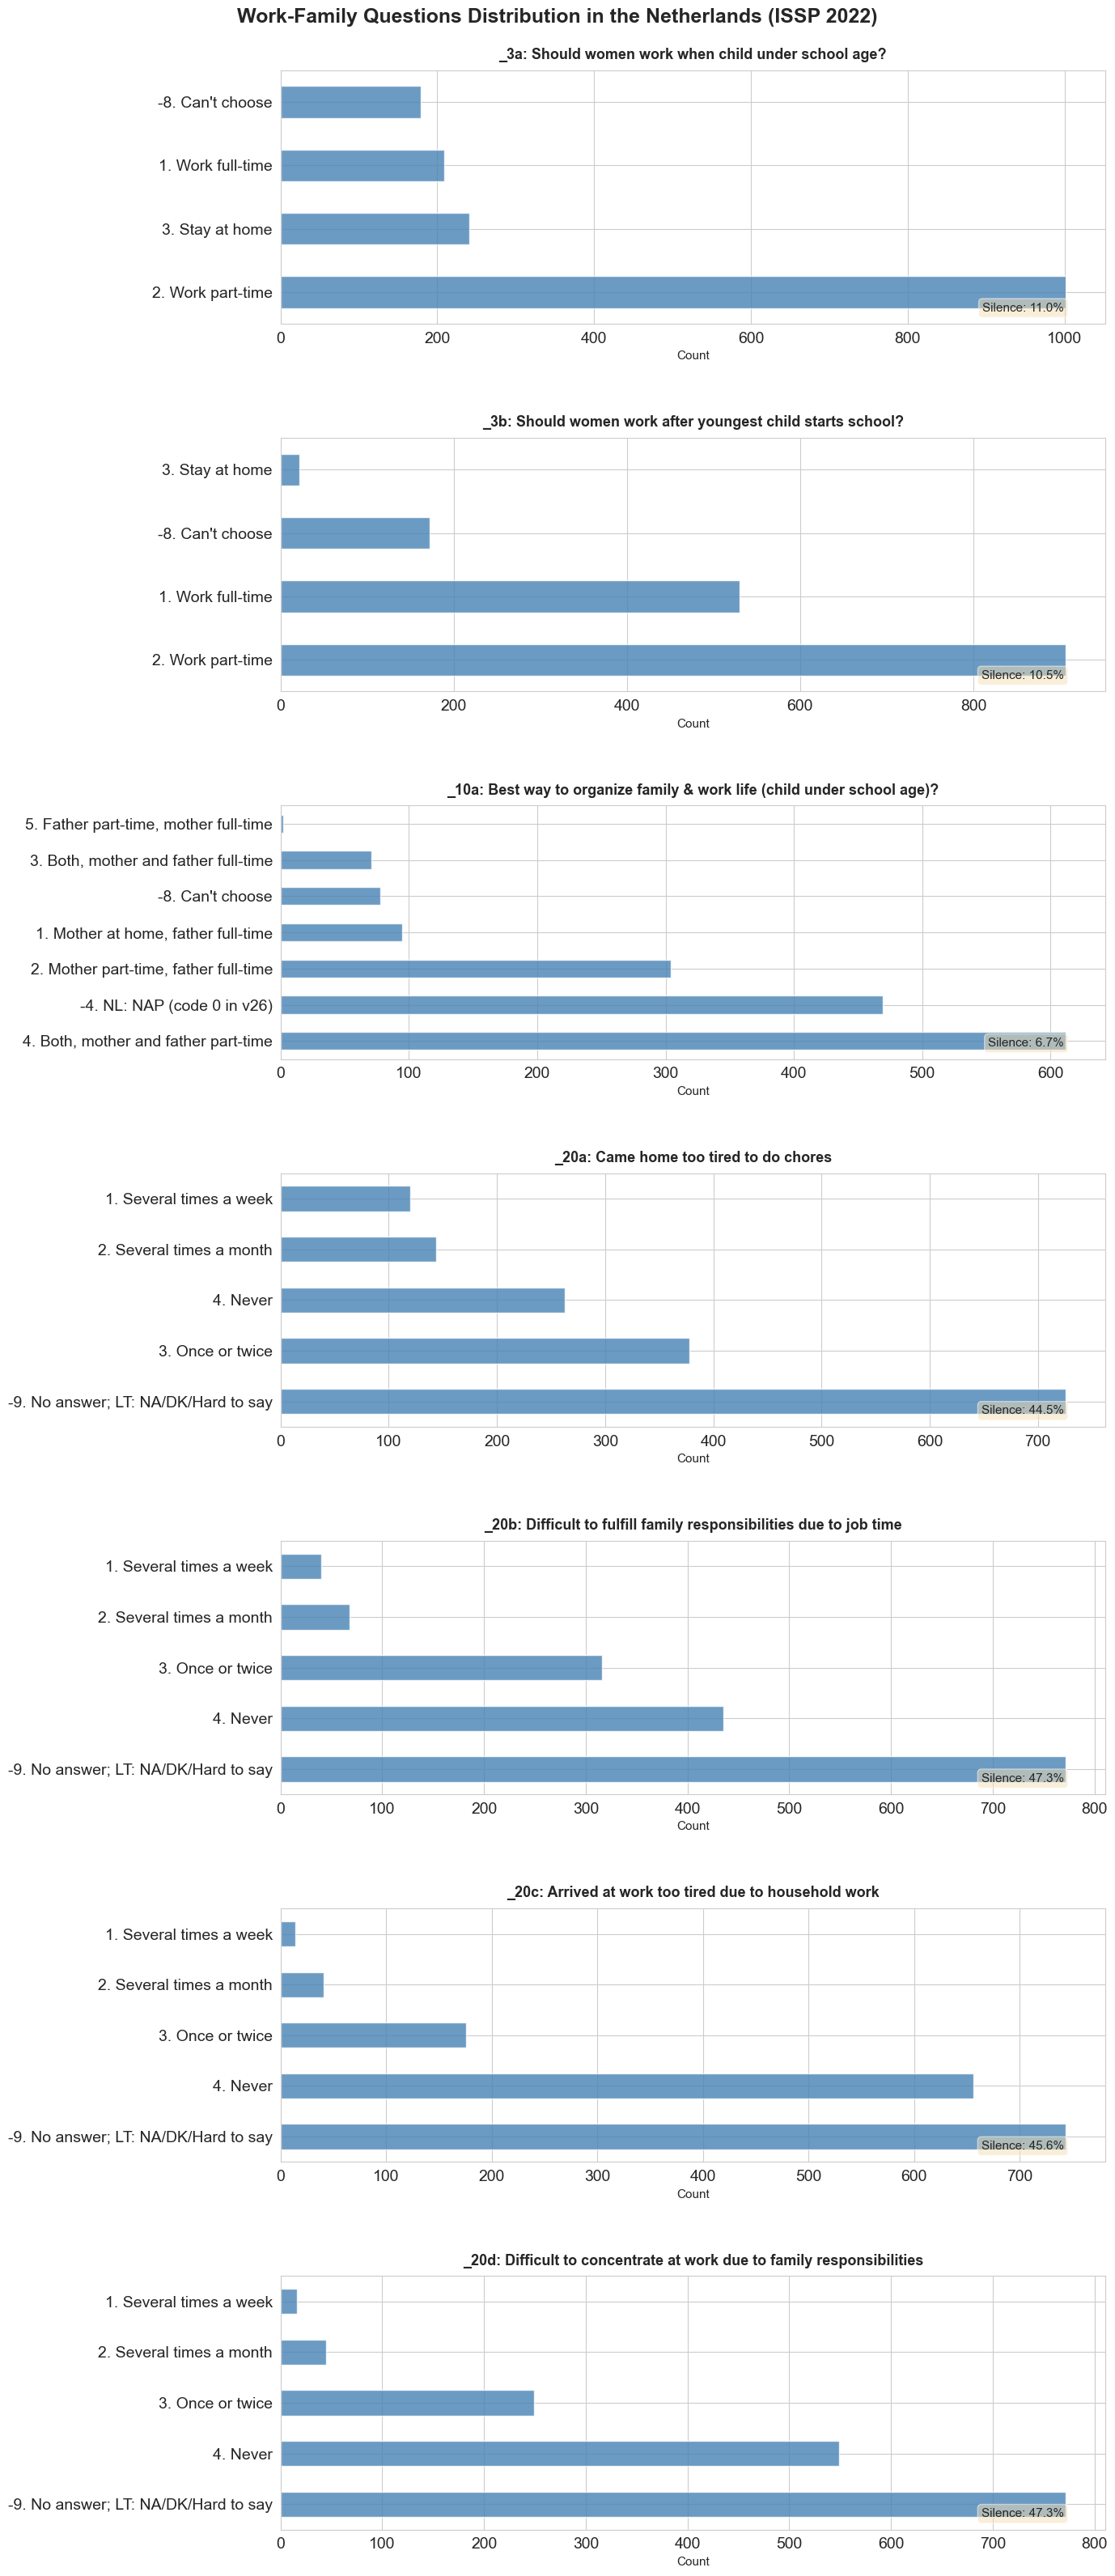

Summary: Work-Family Silence Rates in Netherlands
----------------------------------------------------------------------
_3a: 10.97% silence - Should women work when child under school age?
_3b: 10.55% silence - Should women work after youngest child starts school?
_10a: 6.71% silence - Best way to organize family & work life (child under school age)?
_20a: 44.51% silence - Came home too tired to do chores
_20b: 47.33% silence - Difficult to fulfill family responsibilities due to job time
_20c: 45.62% silence - Arrived at work too tired due to household work
_20d: 47.33% silence - Difficult to concentrate at work due to family responsibilities


In [20]:
# Work-family questions distribution in the Netherlands
work_family_qs = ["_3a", "_3b", "_10a", "_20a", "_20b", "_20c", "_20d"]

# Question labels with full text
question_labels = {
    "_3a": "Should women work when child under school age?",
    "_3b": "Should women work after youngest child starts school?",
    "_10a": "Best way to organize family & work life (child under school age)?",
    "_20a": "Came home too tired to do chores",
    "_20b": "Difficult to fulfill family responsibilities due to job time",
    "_20c": "Arrived at work too tired due to household work",
    "_20d": "Difficult to concentrate at work due to family responsibilities"
}

# Filter Netherlands data
netherlands_2022 = df_2022[df_2022['country'] == 'Netherlands']

# Show distribution for each question - 1 column layout
fig, axes = plt.subplots(7, 1, figsize=(14, 32))

for i, q in enumerate(work_family_qs):
    if q in netherlands_2022.columns:
        ax = axes[i]
        
        # Get value counts
        value_counts = netherlands_2022[q].value_counts()
        
        # Plot
        value_counts.plot(kind='barh', ax=ax, color='steelblue', alpha=0.8)
        ax.set_title(f'{q}: {question_labels[q]}', fontsize=13, fontweight='bold', pad=10)
        ax.set_xlabel('Count', fontsize=11)
        ax.set_ylabel('')
        
        # Calculate silence rate for this question
        silence_rate = silence_rate_for_column(netherlands_2022, q) * 100
        ax.text(0.95, 0.05, f'Silence: {silence_rate:.1f}%', 
                transform=ax.transAxes, ha='right', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Work-Family Questions Distribution in the Netherlands (ISSP 2022)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.subplots_adjust(hspace=0.45)
plt.show()

# Summary table
print("Summary: Work-Family Silence Rates in Netherlands")
print("-" * 70)
for q in work_family_qs:
    if q in netherlands_2022.columns:
        rate = silence_rate_for_column(netherlands_2022, q) * 100
        print(f"{q}: {rate:.2f}% silence - {question_labels[q]}")

A deeper analysis of the Netherlands data reveals a dramatic picture, which only became fully clear after we deconstructed the general **Work-family** category into individual questions. While the average might imply a silence rate of around 30%, diving into the specific personal questions exposes that the refusal to answer actually spikes to a peak of over **40%**, reaching as high as **47%** in some cases!

The data highlights a sharp dichotomy: When Netherlands respondents are asked about general societal norms - such as whether women should work or how a family *ought* to be organized - they answer with ease, showing low silence rates (between 6% and 11%). This indicates a cultural comfort with expressing opinions on public policy and social standards.

However, this openness vanishes the moment the questions turn to the personal sphere. When asked about specific internal conflicts - such as returning home "too tired to do chores" - the silence rate skyrockets to the **44%–47%** range! It appears that while the Netherlands are happy to critique external social structures, they are deeply resistant to exposing their own internal struggles or admitting to a lack of balance in their private lives to a surveyor.

Why do these gaps exist? We could guess, but we’re students, not Netherlands sociologists, so we’ll pass the speaking rights to GPT: 

> This behavior is best understood through the unique Netherlands labor model. According to **[Eurostat](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Part-time_and_full-time_employment_-_statistics)**, the Netherlands has the highest share of part-time employment in Europe, where many workers voluntarily choose this path to maintain balance. Furthermore, the **[OECD Better Life Index](https://www.oecdbetterlifeindex.org/topics/work-life-balance/)** consistently ranks the Netherlands as the number one country in the world for work-life balance. In a culture that values privacy and enjoys high satisfaction with leisure time, respondents may view questions about "exhaustion" as an irrelevant intrusion, or simply refuse to "complain" about a lifestyle they have freely chosen and successfully managed.

### 3.4 Normalizing most avoided topics

If we take more serious look at the heatmap from the beginning of this section, we will see that some countries appear to talk very little about nearly every topic, which makes it misleading to rank their “most avoided” category based only on their own internal levels. 

To get a meaningful signal, we decide to normalize the heatmap **by topic**, comparing each country’s attention to the global average for that category. This lets us see which subjects a country is truly unusually silent about, instead of just generally quiet about everything.

In [21]:
# Column-wise Z-score: How does this country compare to OTHER countries on each topic?
df_normalized = df_plot.copy()

# Calculate mean and std for each CATEGORY (column) across all countries
category_means = df_plot.mean(axis=0)  # Global average per topic
category_stds = df_plot.std(axis=0)    # Global std per topic

# Normalize: How many std deviations above/below the GLOBAL average for that topic?
for col in df_plot.columns:
    df_normalized[col] = (df_plot[col] - category_means[col]) / category_stds[col]

# Find which category is most UNUSUALLY silent for each country (relative to global norms)
most_unusual_category = df_normalized.idxmax(axis=1)
max_zscore = df_normalized.max(axis=1)

comparison_df = pd.DataFrame({
    'Most Silent (Absolute)': most_silent_category,
    'Silence Rate (%)': max_silence_rate.round(1),
    'Most Silent (Normalized)': most_unusual_category,
    'Z-Score': max_zscore.round(2)
}).sort_values('Z-Score', ascending=False)

comparison_df

,Most Silent (Absolute),Silence Rate (%),Most Silent (Normalized),Z-Score
Country,,,,
Japan,Women leadership,14.5,New families,4.23
Iceland,Work-family,12.9,Wellbeing,3.68
Netherlands,Work-family,30.4,Work-family,3.24
United States,Work-family,14.4,Household chores,2.90
Australia,Work-family,18.3,Parental roles,2.78
Germany,Work-family,24.3,Work-family,2.36
Sweden,Work-family,11.1,Gender attitudes,2.11
Lithuania,Work-family,7.4,Gender attitudes,1.71
Finland,Work-family,8.5,Gender attitudes,1.53


In simple terms, the **Z-Score** tells us how "abnormal" a country's silence is compared to the rest of the world.

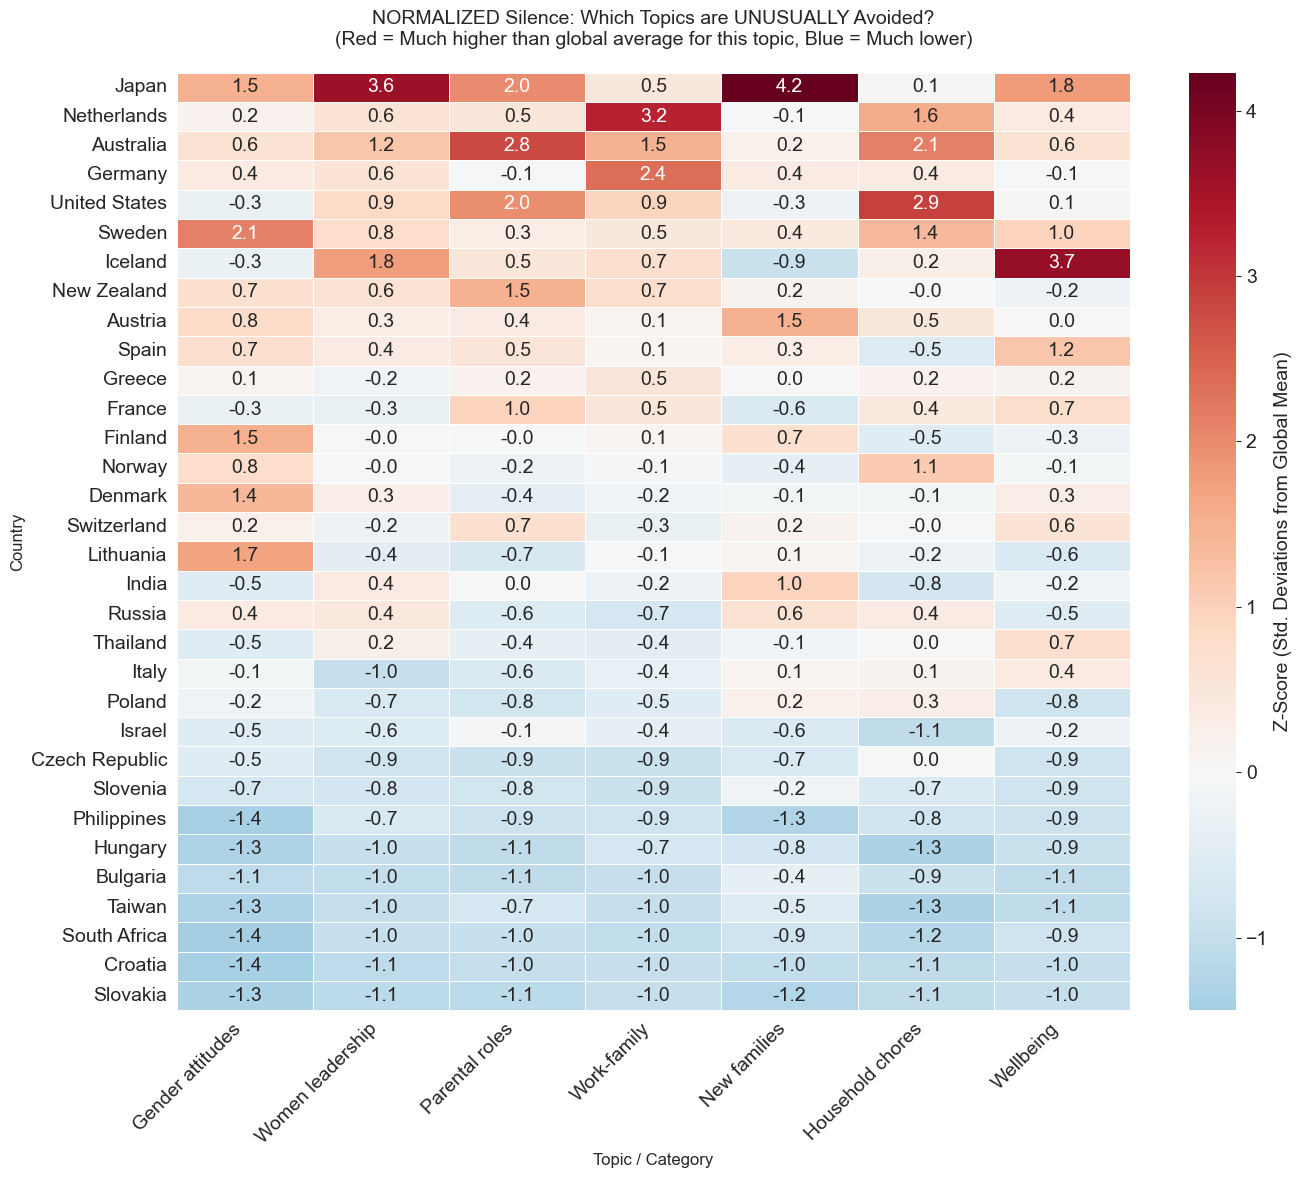

In [22]:
# Visualize the normalized heatmap
plt.figure(figsize=(14, 12))

sns.heatmap(df_normalized, 
            annot=True, 
            fmt=".1f", 
            cmap="RdBu_r",  # Red = unusually high vs global, Blue = unusually low
            center=0,       # Center colormap at 0 (global average)
            linewidths=.5, 
            cbar_kws={'label': 'Z-Score (Std. Deviations from Global Mean)'})

plt.title('NORMALIZED Silence: Which Topics are UNUSUALLY Avoided?\n(Red = Much higher than global average for this topic, Blue = Much lower)', 
          fontsize=14, pad=20)
plt.ylabel('Country', fontsize=12)
plt.xlabel('Topic / Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In this heatmap, we interpret the Z-Scores as follows:

*   **Global Average (0):** If a country creates a score of 0, it means their silence on this topic is exactly average.
*   **Positive Z-Score (Red):** The country is **more silent** than the global norm. For example, a score of `+2.0` means their silence rate is extremely high—two standard deviations above what we typically see for this topic.
*   **Negative Z-Score (Blue):** The country is **more open** (less silent) than the global norm.

### 3.5 Comparing absolute vs normalized most avoided topics

After we create the normalized heatmap, let's compare how many countries changed their #1 silent topic:

After normalization:
  • 9 countries (28%) - Same #1 topic (truly unusual silence)
  • 23 countries (72%) - DIFFERENT #1 topic (was just generally silent)

Countries where normalization revealed a DIFFERENT sensitive topic:


,Country,Absolute #1 Topic,Normalized #1 Topic
0,Japan,Women leadership,New families
1,Australia,Work-family,Parental roles
2,United States,Work-family,Household chores
3,Sweden,Work-family,Gender attitudes
4,Iceland,Work-family,Wellbeing
5,New Zealand,Work-family,Parental roles
6,Austria,Work-family,New families
7,Spain,Work-family,Wellbeing
8,France,Work-family,Parental roles
9,Finland,Work-family,Gender attitudes


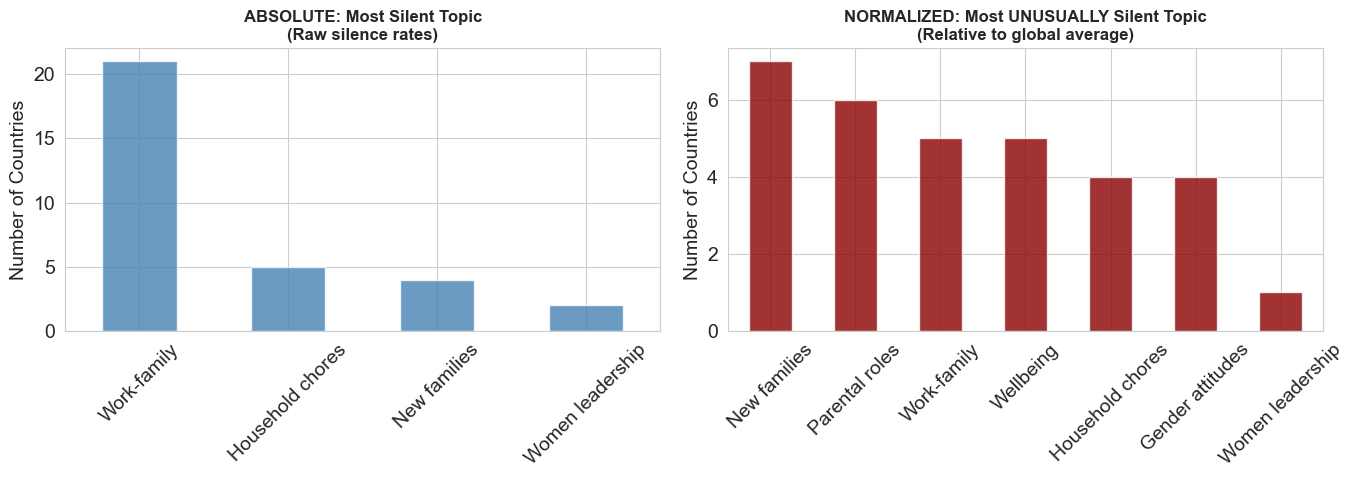

In [23]:
changed_mask = most_silent_category != most_unusual_category
n_changed = changed_mask.sum()
n_same = (~changed_mask).sum()

print(f"After normalization:")
print(f"  • {n_same} countries ({n_same/len(most_silent_category)*100:.0f}%) - Same #1 topic (truly unusual silence)")
print(f"  • {n_changed} countries ({n_changed/len(most_silent_category)*100:.0f}%) - DIFFERENT #1 topic (was just generally silent)")

# Create DataFrame for countries that changed - use .loc to avoid warning
changed_countries = changed_mask[changed_mask].index.tolist()
changed_countries_df = comparison_df.loc[changed_countries, ['Most Silent (Absolute)', 'Most Silent (Normalized)']].copy()
changed_countries_df.columns = ['Absolute #1 Topic', 'Normalized #1 Topic']
changed_countries_df = changed_countries_df.reset_index().rename(columns={'index': 'Country'})

print(f"\nCountries where normalization revealed a DIFFERENT sensitive topic:")
display(changed_countries_df)

# Count normalized categories
normalized_counts = most_unusual_category.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute counts
ax1 = axes[0]
category_counts.plot(kind='bar', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('ABSOLUTE: Most Silent Topic\n(Raw silence rates)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Countries')
ax1.tick_params(axis='x', rotation=45)

# Right: Normalized counts  
ax2 = axes[1]
normalized_counts.plot(kind='bar', ax=ax2, color='darkred', alpha=0.8)
ax2.set_title('NORMALIZED: Most UNUSUALLY Silent Topic\n(Relative to global average)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Countries')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In the absolute chart, 'Work-family' is by far the most common silent topic. However, after normalizing the data, the focus shifts to 'New families.' This means that while 'Work-family' has the highest raw numbers, 'New families' is the most unusually silent topic compared to the global average.

### 3.6 japan taboo gap analysis

Japan showed an extreme Z-Score of 4.2 on "Women Leadership" questions. This is the highest normalized silence of any country on any topic in our heatmap!

It's worth investigating why Japan is so unusually silent on this topic compared to other countries.

In [24]:
# Japan Anomaly Investigation - Setup
leadership_cols = ['_27a', '_27b', '_27c']
control_cols = ['_1a', '_1b', '_1c']

japan = df_2022[df_2022['country'] == 'Japan'].copy()
germany = df_2022[df_2022['country'] == 'Germany'].copy()
sweden = df_2022[df_2022['country'] == 'Sweden'].copy()

def calc_silence(df, cols):
    valid = [c for c in cols if c in df.columns]
    if not valid: return np.nan
    return df[valid].map(is_silence_value).mean().mean() * 100

def get_gender(val):
    s = str(val).lower()
    if s.startswith('1') or (s == 'male'): return 'Male'
    if '2' in s or 'female' in s: return 'Female'
    return np.nan

japan['gender'] = japan['SEX'].apply(get_gender)
japan['age_num'] = japan['AGE'].apply(lambda x: int(re.match(r'^(\d+)', str(x).strip()).group(1)) if pd.notna(x) and re.match(r'^(\d+)', str(x).strip()) else np.nan)
japan['age_group'] = pd.cut(japan['age_num'], bins=[0, 35, 55, 100], labels=['18-35', '36-55', '55+'])

Here we check if **men or women** are driving this silence. We compare Leadership silence (a sensitive topic) to Work-Family silence (a control topic) to measure the "Taboo Gap".

In [25]:
# Gender analysis in Japan
gender_data = {g: {'N': len(japan[japan['gender']==g]), 
                   'Leadership (%)': calc_silence(japan[japan['gender']==g], leadership_cols),
                   'Control (%)': calc_silence(japan[japan['gender']==g], control_cols)} 
               for g in ['Male', 'Female']}
gender_df = pd.DataFrame(gender_data).T
gender_df['Taboo Gap'] = gender_df['Leadership (%)'] - gender_df['Control (%)']
gender_df.round(2)

,N,Leadership (%),Control (%),Taboo Gap
Male,664.0,13.81,5.87,7.93
Female,762.0,15.14,5.34,9.80


Both genders show high silence on Women Leadership (~14-15%), but **women have a larger "Taboo Gap"** (9.8% vs 7.9%). This means women in Japan are *relatively* more reluctant to discuss leadership compared to everyday topics. The silence is cultural (affects both genders), but the *sensitivity* is slightly stronger among women.

Now we break down the silence by **age group** within each gender. This helps us see if older or younger Japanese respondents are more silent on women's leadership.

In [26]:
# Age × Gender breakdown
breakdown = []
for g in ['Male', 'Female']:
    for a in ['18-35', '36-55', '55+']:
        sub = japan[(japan['gender']==g) & (japan['age_group']==a)]
        if len(sub) > 0:
            breakdown.append({'Gender': g, 'Age': a, 'N': len(sub), 
                            'Leadership (%)': calc_silence(sub, leadership_cols),
                            'Control (%)': calc_silence(sub, control_cols)})
breakdown_df = pd.DataFrame(breakdown)
breakdown_df['Taboo Gap'] = breakdown_df['Leadership (%)'] - breakdown_df['Control (%)']
breakdown_df.round(2)

,Gender,Age,N,Leadership (%),Control (%),Taboo Gap
0,Male,18-35,93,15.41,8.24,7.17
1,Male,36-55,226,10.03,3.39,6.64
2,Male,55+,345,15.85,6.86,8.99
3,Female,18-35,130,14.62,5.13,9.49
4,Female,36-55,241,14.38,4.43,9.96
5,Female,55+,391,15.77,5.97,9.80


We observe distinct generational patterns, with a consistent gender gap across all ages:

1.  **Women's Consistent Sensitivity:** Across all age groups (18-35, 36-55, 55+), the "Taboo Gap" for women remains remarkably stable at around **9.5% - 10%**. This suggests that the reluctance to discuss female leadership is a pervasive cultural norm for Japanese women, not limited to a specific generation.

2.  **Men's "Working Age" Openness:** Men aged 36-55 show the lowest silence rates (10.03%) and the smallest Taboo Gap (6.64%). This age group, likely representing the active workforce, appears most willing to engage with these questions.

3.  **The Gender Gap Persists:** In every single age category, women have a higher Taboo Gap than men. Even among the younger generation (18-35), where we might expect more progressive attitudes, women are still significantly more hesitant to discuss leadership (Gap 9.49%) compared to young men (Gap 7.17%).

### 3.7 Iceland Anomaly Investigation

The Nordic countries - Sweden, Norway, Denmark, Finland, and Iceland - are often grouped together as a single cultural and social “family.” They share similar histories, strong welfare states, high levels of trust in institutions, and cultural norms that emphasize modesty, privacy, and emotional restraint. Because of these shared traits, we expect them to behave in similar ways in surveys, especially on sensitive topics like wellbeing, work, and family life.

However, from the heatmap above, it seems like Iceland is a different case. Let’s take a closer look at this.

In [27]:
# Iceland Anomaly - Setup
wellbeing_cols = ['_26', '_28a', '_28b']  # Happy, Stress/Depression, Quality of life
control_cols_ice = ['_1a', '_1b', '_1c']  # Work-family as control

# Define country clusters
nordic_countries = ['Sweden', 'Norway', 'Denmark', 'Finland']
iceland = df_2022[df_2022['country'] == 'Iceland'].copy()
nordics = df_2022[df_2022['country'].isin(nordic_countries)].copy()
rest_of_world = df_2022[~df_2022['country'].isin(nordic_countries + ['Iceland'])].copy()

def calc_silence_ice(df, cols):
    valid = [c for c in cols if c in df.columns]
    if not valid: return np.nan
    return df[valid].map(is_silence_value).mean().mean() * 100

print(f"Sample sizes: Iceland={len(iceland)}, Nordics={len(nordics)}, Rest of World={len(rest_of_world)}")

Sample sizes: Iceland=1220, Nordics=5487, Rest of World=39055


We comparing Wellbeing silence across three groups: Iceland alone, other Nordic countries (Sweden, Norway, Denmark, Finland), and the rest of the world. 

If Iceland stands out even among Nordics, it's a **local phenomenon**. If all Nordics are high, it's a **regional cultural trait**.

In [28]:
# Nordic Silence Gradient
gradient_data = [
    {'Region': 'Iceland', 'N': len(iceland), 
     'Wellbeing Silence (%)': calc_silence_ice(iceland, wellbeing_cols),
     'Control Silence (%)': calc_silence_ice(iceland, control_cols_ice)},
    {'Region': 'Other Nordics', 'N': len(nordics), 
     'Wellbeing Silence (%)': calc_silence_ice(nordics, wellbeing_cols),
     'Control Silence (%)': calc_silence_ice(nordics, control_cols_ice)},
    {'Region': 'Rest of World', 'N': len(rest_of_world), 
     'Wellbeing Silence (%)': calc_silence_ice(rest_of_world, wellbeing_cols),
     'Control Silence (%)': calc_silence_ice(rest_of_world, control_cols_ice)}
]
gradient_df = pd.DataFrame(gradient_data)
gradient_df['Taboo Gap'] = gradient_df['Wellbeing Silence (%)'] - gradient_df['Control Silence (%)']
gradient_df.round(2)

,Region,N,Wellbeing Silence (%),Control Silence (%),Taboo Gap
0,Iceland,1220,8.91,1.34,7.57
1,Other Nordics,5487,2.68,3.19,-0.51
2,Rest of World,39055,1.93,1.96,-0.03


The data strongly suggests that this is an **Iceland-specific phenomenon**, not a regional Nordic trait.

*   **Iceland's Extreme Gap:** Iceland stands alone with a massive **7.57% "Taboo Gap"**. While they are extremely open about everyday topics (Control Silence is only 1.34%), they become significantly more silent when asked about personal wellbeing.
*   **Nordic Openness:** "Other Nordic" countries (Sweden, Norway, Denmark, Finland) behave completely differently. Their Taboo Gap is effectively zero (-0.51%), meaning they are just as comfortable discussing mental health as they are any other topic.
*   **Rest of World:** The global average also clearly shows that wellbeing is not typically a "sensitive" topic (Gap of -0.03%).

This isolates the "Happiness Silence" as a unique cultural feature of Iceland, rather than a broader Scandinavian characteristic.

In [29]:
# Individual Nordic breakdown
nordic_breakdown = []
for country in ['Iceland'] + nordic_countries:
    country_df = df_2022[df_2022['country'] == country]
    if len(country_df) > 0:
        nordic_breakdown.append({
            'Country': country,
            'N': len(country_df),
            'Wellbeing Silence (%)': calc_silence_ice(country_df, wellbeing_cols),
            'Control Silence (%)': calc_silence_ice(country_df, control_cols_ice)
        })
nordic_df = pd.DataFrame(nordic_breakdown)
nordic_df['Taboo Gap'] = nordic_df['Wellbeing Silence (%)'] - nordic_df['Control Silence (%)']
nordic_df = nordic_df.sort_values('Wellbeing Silence (%)', ascending=False)
nordic_df.round(2)

,Country,N,Wellbeing Silence (%),Control Silence (%),Taboo Gap
0,Iceland,1220,8.91,1.34,7.57
1,Sweden,1613,3.97,4.07,-0.10
3,Denmark,1430,2.73,2.31,0.42
2,Norway,1194,1.93,3.52,-1.59
4,Finland,1250,1.68,2.75,-1.07


When we break down the Nordic cluster into individual countries, the contrast becomes even sharper.
While **Sweden, Denmark, Norway, and Finland** all show negligible or even negative differences (meaning they are *more* open about wellbeing than control topics), **Iceland** is the outlier. The fact that Norway and Finland actually have negative gaps (-1.59% and -1.07%) highlights just how unusual the Icelandic result is.

Why does Iceland behave so differently? We honestly don’t know. We’re just students, and we don’t have direct knowledge of Icelandic society or people there. To complete the picture, we asked GPT for a possible explanation. The floor is yours:

> A compelling hypothesis is the **"Small Population Paradox"**. Iceland has a very small population (~370,000 people). In such a tight-knit society where "everyone knows everyone", the anonymity of a survey might feel less secure. Respondents might irrationally fear that revealing sensitive information—like being unhappy or depressed—could somehow be traced back to them or affect their social standing. In contrast, the larger populations of Sweden (10M) or Finland (5.5M) naturally provide a stronger sense of anonymity. This social pressure in a small community could explain the distinct hesitation to record negative emotions on paper, even if the survey is technically anonymous.

___

## 4. Detailed Gender Attitudes Breakdown

In this section, we provide a detailed analysis of gender-traditional attitudes in Israel based on five key questions asked across three decades: 2002, 2012, and 2022. 

Rather than focusing on the content of the responses themselves, our analysis specifically centers on respondents who opted not to answer these questions. 

- **1a** explores working mothers and child attachment.

- **1b** asks if pre-school children suffer when mom works. 

- **1c** examines whether family life suffers from mom's full-time job.

- **1d** probes if women prefer home/children over paid work. 

- **1e** tests whether being a housewife feels as fulfilling as paid employment.

By concentrating on patterns of non-response, this analysis highlights hesitation, discomfort, or social ambiguity surrounding sensitive gender norms, offering insight beyond expressed attitudes alone.

In [30]:
q1_questions = ["_1a", "_1b", "_1c", "_1d", "_1e"]

# Filter Israel only from country column
israel_2002 = df_2002[df_2002['C_ALPHAN'] == 'IL']
israel_2012 = df_2012[df_2012['C_ALPHAN'] == 'IL']
israel_2022 = df_2022[df_2022['country'] == 'Israel']

years_data = {
    2002: israel_2002,
    2012: israel_2012, 
    2022: israel_2022
}

print("Israel sample sizes per year:")
for year, df in years_data.items():
    print(f"{year}: {len(df)} respondents")


Israel sample sizes per year:
2002: 1209 respondents
2012: 1220 respondents
2022: 1187 respondents


In [31]:
# Calculate silence RATE (%) for each question
silence_data_percent = {}
for year, df_israel in years_data.items():
    silence_data_percent[year] = {}
    for q in q1_questions:
        if q in df_israel.columns:
            rate_percent = silence_rate_for_column(df_israel, q) * 100
            silence_data_percent[year][q] = rate_percent

# DataFrame
q1_silence_percent = pd.DataFrame(silence_data_percent).T
q1_silence_percent = q1_silence_percent.round(2)

q1_silence_percent


,_1a,_1b,_1c,_1d,_1e
2002,0.58,1.32,0.74,2.81,2.98
2012,2.46,2.05,2.46,5.74,6.07
2022,2.53,1.60,1.18,2.02,4.63


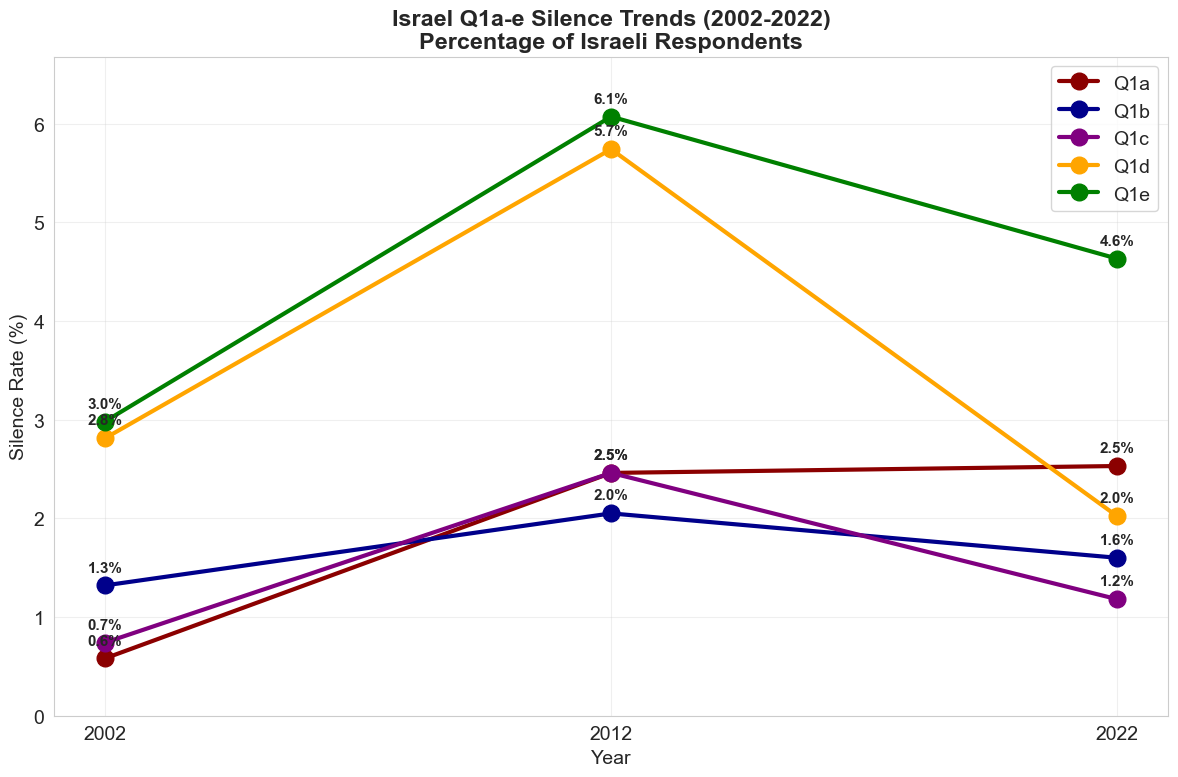

In [32]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})

colors = ['darkred', 'darkblue', 'purple', 'orange', 'green']
labels = ['Q1a', 'Q1b', 'Q1c', 'Q1d', 'Q1e']

for i, q in enumerate(q1_questions):
    if q in q1_silence_percent.columns:
        plt.plot(q1_silence_percent.index, q1_silence_percent[q], 
                marker='o', linewidth=3, markersize=12,
                color=colors[i], label=labels[i])

plt.xlabel('Year')
plt.ylabel('Silence Rate (%)')
plt.title('Israel Q1a-e Silence Trends (2002-2022)\nPercentage of Israeli Respondents', fontweight='bold')
plt.legend()
plt.xticks([2002, 2012, 2022])
plt.grid(True, alpha=0.3)
plt.ylim(0, q1_silence_percent.max().max()*1.1)

# Add % labels on points
for q in q1_questions:
    if q in q1_silence_percent.columns:
        for year in q1_silence_percent.index:
            val = q1_silence_percent.loc[year, q]
            plt.annotate(f'{val:.1f}%', 
                        (year, val), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


In [33]:
# Summary stats DataFrame
q1_summary = pd.DataFrame({
    'Question': ['Q1a', 'Q1b', 'Q1c', 'Q1d', 'Q1e'],
    'Mean_3yrs_%': q1_silence_percent.mean(axis=0).round(2),
    'Trend_2002_2022': (q1_silence_percent.loc[2022] - q1_silence_percent.loc[2002]).round(2),
    'Max_Year': q1_silence_percent.idxmax(axis=0).values
})

print("Q1a-e Summary Statistics:")
q1_summary


Q1a-e Summary Statistics:


,Question,Mean_3yrs_%,Trend_2002_2022,Max_Year
_1a,Q1a,1.86,1.95,2022
_1b,Q1b,1.66,0.28,2012
_1c,Q1c,1.46,0.44,2012
_1d,Q1d,3.52,-0.79,2012
_1e,Q1e,4.56,1.65,2012


**2012 stands out dramatically** as the peak silence year across all five gender questions. 

Q1d ("women prefer home/children") hit **5.74% silence**, Q1e ("housewife fulfilling") reached **6.07%**, and even milder Q1a jumped from 0.58% (2002) to **2.46%**. This **3-4x increase** cannot be random – something specific happened in Israeli society that year.

**Key 2012 events explain this spike:**
1. **Social protests peak** (July 2011-January 2012): Mass demonstrations against **cost of living** exposed **working women struggles**. Gender roles became politicized overnight.
2. **Pre-election polarization** (October 2012 Knesset elections): Gender became a wedge issue between secular feminists vs religious traditionalists.

## 5. Multiple Linear Regression: What Predicts Silence?

In this section, we build a multiple linear regression model to identify key predictors of silence. It was much harder than we thought...

In [34]:
import statsmodels.api as sm
import re

def extract_leading_int(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s.lower() == 'nan' or s == '':
        return np.nan
    
    match = re.match(r'^(-?\d+)', s)
    if match:
        num = int(match.group(1))
        if num in [-8, -9]:
            return np.nan
        return num
    return np.nan

all_questions = [col for col in df_2022.columns if col.startswith('_')]
silence_matrix = df_2022[all_questions].map(is_silence_value)
n_silences = silence_matrix.sum(axis=1)
df_2022 = df_2022.copy()
df_2022['n_silences'] = n_silences

### 5.1 Model A: Demographic Model (AGE, EDUCYRS, TOPBOT)

In [35]:
model_a_cols = ['n_silences', 'AGE', 'EDUCYRS', 'TOPBOT']
df_model_a = df_2022[model_a_cols].copy()

for col in ['AGE', 'EDUCYRS', 'TOPBOT']:
    df_model_a[col] = df_model_a[col].apply(extract_leading_int)

# Drop rows with missing values
df_model_a = df_model_a.dropna()

# Define X and y
X_a = df_model_a[['AGE', 'EDUCYRS', 'TOPBOT']]
y_a = df_model_a['n_silences']

# Add constant for intercept (beta_0)
X_a = sm.add_constant(X_a)

# Fit OLS model
model_a = sm.OLS(y_a, X_a).fit()
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:             n_silences   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     282.7
Date:                Sun, 11 Jan 2026   Prob (F-statistic):          1.08e-181
Time:                        23:02:32   Log-Likelihood:            -1.1462e+05
No. Observations:               41969   AIC:                         2.292e+05
Df Residuals:                   41965   BIC:                         2.293e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2564      0.090      2.850      0.0

| Variable | Coefficient | Meaning |
|----------|-------------|---------|
| **AGE** | +0.027 | Each additional year of age → +0.027 more silences. A 70-year-old has ~1.35 more silences than a 20-year-old |
| **EDUCYRS** | +0.031 | Each year of education → +0.031 more silences. Surprisingly, more educated people are slightly MORE silent |
| **TOPBOT** | +0.098 | Higher social status → more silence. Moving up 1 point on the 1-10 scale adds ~0.1 silences |

**Model Quality:** R² = 0.020 means demographics explain only **2% of variance** in silence behavior. This is very low! The demographic hypothesis has some truth but is NOT the main driver of non-response.

**This model was a disaster,** so we try to build a different model.

### 5.2 Model B: Household Complexity Model (HOMPOP, HHADULT)

In [36]:
model_b_cols = ['n_silences', 'HOMPOP', 'HHADULT']
df_model_b = df_2022[model_b_cols].copy()

for col in ['HOMPOP', 'HHADULT']:
    df_model_b[col] = df_model_b[col].apply(extract_leading_int)

df_model_b = df_model_b.dropna()
print(f"Model B sample size after cleaning: {len(df_model_b)}")

# Define X and y
X_b = df_model_b[['HOMPOP', 'HHADULT']]
y_b = df_model_b['n_silences']

# Add constant for intercept (beta_0)
X_b = sm.add_constant(X_b)

# Fit OLS model
model_b = sm.OLS(y_b, X_b).fit()
print(model_b.summary())

Model B sample size after cleaning: 44202
                            OLS Regression Results                            
Dep. Variable:             n_silences   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     181.8
Date:                Sun, 11 Jan 2026   Prob (F-statistic):           2.22e-79
Time:                        23:02:32   Log-Likelihood:            -1.2716e+05
No. Observations:               44202   AIC:                         2.543e+05
Df Residuals:                   44199   BIC:                         2.543e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

| Variable | Coefficient | P-value | Meaning |
|----------|-------------|---------|---------|
| **HOMPOP** | -0.257 | <0.001 | Each additional person in household → **0.26 FEWER** silences |
| **HHADULT** | +0.062 | 0.034 | Each additional adult → +0.06 more silences (weak effect) |

**Model Quality:** R² = 0.008 means household size explains only **0.8% of variance** - even weaker than the demographic model!!!

The last two models didn’t do the job properly. We’ll try to approach the problem from a different angle.

### 5.3 Model C: Cross-Category Silence - Does Silence in "Easy" Topics Predict Silence in "Hard" Topics?

**Our hypothesis:** If someone refuses to answer questions in categories with LOW silence rates (easy topics like Parental roles, Wellbeing), they are likely a "silent personality" who will also refuse the HARD topics (Work-family).

**Silence rates by category:**
| Category | Silence Rate | Role in Model |
|----------|-------------|---------------|
| Work-family | 11.1% | **TARGET** (hardest to answer) |
| Household chores | 4.7% | Predictor |
| New families | 4.3% | Predictor |
| Women leadership | 4.2% | Predictor |
| Gender attitudes | 4.0% | Predictor |
| Wellbeing | 2.8% | Predictor |
| Parental roles | 2.2% | Predictor (easiest) |

In [37]:
df_category_silence_person = df_2022[['country']].copy()

for cat_name, questions in categories.items():
    valid_qs = [q for q in questions if q in df_2022.columns]
    if valid_qs:
        silence_matrix = df_2022[valid_qs].map(is_silence_value)
        df_category_silence_person[f'silence_{cat_name}'] = silence_matrix.mean(axis=1)

# Create binary target: Did person have ANY silence in Work-family category?
# (more than 0% silence = refused at least 1 question)
df_category_silence_person['target_work_family_silent'] = (
    df_category_silence_person['silence_Work-family'] > 0
).astype(int)

# Predictors: silence rates in OTHER categories (not Work-family)
predictor_cols = ['silence_Gender attitudes', 'silence_Women leadership', 
                  'silence_Parental roles', 'silence_New families', 
                  'silence_Household chores', 'silence_Wellbeing']

# Drop rows with missing values
df_model_d = df_category_silence_person.dropna()
print(f"Model C sample size: {len(df_model_d)}")
print(f"\nTarget: Work-family silence (any refusal)")
print(f"Positive class (silent): {df_model_d['target_work_family_silent'].sum()} ({df_model_d['target_work_family_silent'].mean()*100:.1f}%)")
print(f"Negative class (answered all): {(1-df_model_d['target_work_family_silent']).sum()}")

# Prepare X and y
X_d = df_model_d[predictor_cols]
y_d = df_model_d['target_work_family_silent']

# Add constant
X_d = sm.add_constant(X_d)

# Fit Logistic Regression
model_d = sm.Logit(y_d, X_d).fit()
print("\n" + "="*60)
print(model_d.summary())

Model C sample size: 45762

Target: Work-family silence (any refusal)
Positive class (silent): 10446 (22.8%)
Negative class (answered all): 35316
Optimization terminated successfully.
         Current function value: 0.486097
         Iterations 7

                               Logit Regression Results                              
Dep. Variable:     target_work_family_silent   No. Observations:                45762
Model:                                 Logit   Df Residuals:                    45755
Method:                                  MLE   Df Model:                            6
Date:                       Sun, 11 Jan 2026   Pseudo R-squ.:                 0.09509
Time:                               23:02:33   Log-Likelihood:                -22245.
converged:                              True   LL-Null:                       -24582.
Covariance Type:                   nonrobust   LLR p-value:                     0.000
                               coef    std err          z      

**Sample:** 45,762 respondents. Of these, 10,446 (22.8%) refused at least one Work-family question.

**Model Performance:**
- Pseudo R² = 9.5% — This is a **major improvement** over Models A and B (which had ~2% and ~1%)
- All predictors are statistically significant (p < 0.001)

**Key Findings - Which silences predict Work-family silence?**

| Predictor Category | Coefficient | Meaning |
|-------------------|-------------|---------|
| **Gender attitudes** | 2.86 | **Strongest predictor!** If someone is silent on gender questions, they are MUCH more likely to be silent on work-family |
| Wellbeing | 1.29 | Second strongest - silence on happiness questions predicts work-family silence |
| Household chores | 1.07 | Silence on housework questions predicts work-family silence |
| New families | 0.87 | Moderate predictor |
| Women leadership | 0.79 | Weaker predictor |
| Parental roles | 0.42 | Weakest predictor |

**Interpretation:**
1. **Silence is contagious across topics** — People who refuse one category tend to refuse others
2. **Gender attitudes is the key** — This category (questions about working mothers, traditional gender roles) is the #1 predictor of work-family silence
3. **This makes theoretical sense** — Gender attitudes and Work-family are thematically related (both about women's role in work vs home)
4. **Parental roles is weakest** — Even though it's the "easiest" category (lowest silence rate), it doesn't strongly predict work-family silence. This suggests the connection is about *topic sensitivity*, not just "silent personality"

Model C Accuracy: 79.50%
Pseudo R²: 0.0951 (9.51%)


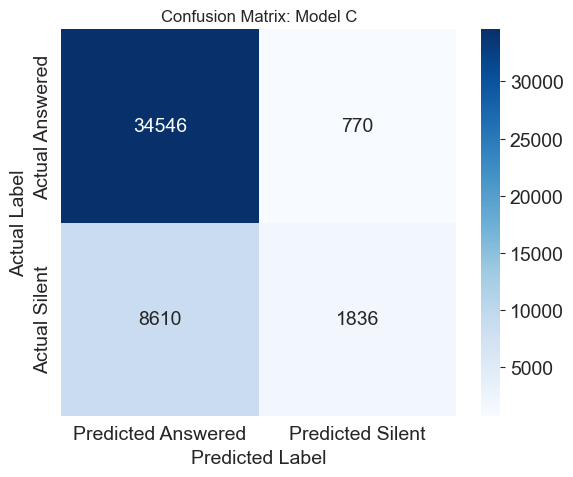


Recall (% of actual silent people we caught): 17.58%
Precision (% of predicted silent who are actually silent): 70.45%


,Odds Ratio,Lower 95% CI,Upper 95% CI,P-value
silence_Parental roles,834.090,565.704,1229.806,0.0
silence_Gender attitudes,17.542,13.960,22.044,0.0
silence_Wellbeing,3.622,2.949,4.448,0.0
silence_Household chores,2.928,2.435,3.520,0.0
silence_New families,2.395,2.037,2.815,0.0
silence_Women leadership,2.194,1.922,2.504,0.0


In [38]:
y_pred_prob = model_d.predict(X_d)
y_pred = (y_pred_prob > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_d, y_pred)
print(f"Model C Accuracy: {accuracy*100:.2f}%")
print(f"Pseudo R²: {model_d.prsquared:.4f} ({model_d.prsquared*100:.2f}%)")

# Visualization of Confusion Matrix
cm = confusion_matrix(y_d, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Answered', 'Predicted Silent'],
            yticklabels=['Actual Answered', 'Actual Silent'])
plt.title('Confusion Matrix: Model C', fontsize=12)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Recall and Precision
if cm[1,1] + cm[1,0] > 0:
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    print(f"\nRecall (% of actual silent people we caught): {recall*100:.2f}%")
    print(f"Precision (% of predicted silent who are actually silent): {precision*100:.2f}%")

# Odds Ratios - which categories are strongest predictors?
odds_ratios = np.exp(model_d.params)
conf_int = np.exp(model_d.conf_int())
conf_int.columns = ['Lower CI', 'Upper CI']

odds_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'Lower 95% CI': conf_int['Lower CI'],
    'Upper 95% CI': conf_int['Upper CI'],
    'P-value': model_d.pvalues
}).drop('const').sort_values('Odds Ratio', ascending=False)

# Display DataFrame
odds_df.round(3)

**Overall Performance:**
- **Accuracy: 79.5%** — The model correctly predicts 4 out of 5 cases
- **Pseudo R² = 9.5%** — Much better than Models A & B (which had 1-2%)

**Confusion Matrix Breakdown:**
- **True Negatives (34,546):** People who answered Work-family AND we predicted they would answer
- **False Positives (770):** People who answered but we wrongly predicted silence
- **False Negatives (8,610):** Silent people we MISSED (predicted they'd answer)
- **True Positives (1,836):** Silent people we correctly caught

**The Trade-off:**
- **Recall = 17.6%** — We only catch 18% of the silent people (we miss most of them!)
- **Precision = 70.5%** — But when we DO predict silence, we're right 70% of the time

**Why low recall?** The model is conservative — it prefers to say "will answer" because 77% of people DO answer. It only predicts silence when it's very confident.

### 5.4 Summary of Modeling Attempts

To be honest, the predictive models we built were not particularly strong.
*   **Model A (Demographics):** Failed to find any meaningful link between age, income, or work hours and silence (explaining only ~2% of the variance).
*   **Model B (Household Structure):** Performed even worse ($R^2 < 1\%$), disproving the idea that "busy parents" are the main source of silence.
*   **Model C (Cross-Topic):** Was the "best" performer, but mostly told us that "people who don't answer X also won't answer Y," which is useful but doesn't explain *who* they are.

The main reason for this difficulty is likely that **"Silent People" do not possess a distinct demographic profile.** It turns out that refusing to answer questions isn't a behavior limited to the poor, the rich, the old, or the busy. Instead, silence likely stems from deeper, unobserved factors that we cannot capture in a standard dataset:
1.  **Personality & Psychology:** Traits like high privacy concerns, distrust of institutions, or social anxiety.
2.  **Situational Factors:** "Survey Fatigue", boredom, or simply having a bad day.
3.  **The "Ghost" Paradox:** By definition, it is extremely difficult to profile people who refuse to share information about themselves. We are essentially trying to predict the behavior of "ghosts" who leave very few traces.

This suggests that silence is a **cultural and psychological phenomenon**, rather than a socioeconomic one.

But we’re not giving up yet! We’ll try one last time, this time by building a KNN model, which we hope will produce encouraging results and let us finish this project on a positive note.

___

# 5. K-Nearest Neighbors Model: Predicting Silence Based on Similar Respondents

In our final modeling attempt, we implement a K-Nearest Neighbors (KNN) algorithm to predict silence based on the behavior of similar respondents.

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

feature_cols = ['AGE', 'EDUCYRS', 'TOPBOT', 'WRKHRS', 'HOMPOP']

df_knn = df_2022[['n_silences'] + feature_cols].copy()

def clean_column(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s.lower() == 'nan' or s == '':
        return np.nan
    
    match = re.match(r'^(-?\d+)', s)
    if match:
        num = int(match.group(1))
        if num in [-8, -9]:
            return np.nan
        return num
    return np.nan

for col in feature_cols:
    df_knn[col] = df_knn[col].apply(clean_column)

df_knn = df_knn.dropna()
median_silences = df_knn['n_silences'].median()

In [40]:
# Create binary target: is_heavy_silencer
# 1 = Heavy Silencer (more silences than median)
# 0 = Normal Responder (silences <= median)
df_knn['is_heavy_silencer'] = (df_knn['n_silences'] > median_silences).astype(int)

print(f"\nClass Distribution:")
print(f"Heavy Silencers (Class 1): {df_knn['is_heavy_silencer'].sum()} ({df_knn['is_heavy_silencer'].mean()*100:.1f}%)")
print(f"Normal Responders (Class 0): {(1-df_knn['is_heavy_silencer']).sum()} ({(1-df_knn['is_heavy_silencer'].mean())*100:.1f}%)")


Class Distribution:
Heavy Silencers (Class 1): 18005 (44.5%)
Normal Responders (Class 0): 22430 (55.5%)


To make this a classification problem, we divided our users into two distinct groups based on their behavior:
*   **Class 1 (Heavy Silencers):** These are the users who fell into the top half of silence rates (above the median). They represent about **44.5%** of the dataset (18,005 people).
*   **Class 0 (Normal Responders):** These are users who answered most questions, representing **55.5%** (22,430 people).

In [41]:
X = df_knn[feature_cols]
y = df_knn['is_heavy_silencer']

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,  # For reproducibility
    stratify=y        # Maintain class balance in both sets
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 32348 samples
Test set: 8087 samples


In [42]:
scaler = StandardScaler()

# IMPORTANT: Fit scaler ONLY on training data (to prevent data leakage)
scaler.fit(X_train)

# Transform both train and test using the SAME scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# will we use K=5 neighbors, but in the next steps we will find k that works better
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)

print("="*60)
print("KNN CLASSIFICATION RESULTS (K=5)")
print("="*60)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nAccuracy: {accuracy_knn*100:.2f}%")

print("\nConfusion Matrix:")
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

tn, fp, fn, tp = cm_knn.ravel()
print(f"\n  True Negatives (Normal correctly identified): {tn}")
print(f"  False Positives (Normal misclassified as Heavy): {fp}")
print(f"  False Negatives (Heavy Silencers MISSED): {fn}")
print(f"  True Positives (Heavy Silencers correctly identified): {tp}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, 
                            target_names=['Normal Responder', 'Heavy Silencer']))

KNN CLASSIFICATION RESULTS (K=5)

Accuracy: 56.10%

Confusion Matrix:
[[2868 1618]
 [1932 1669]]

  True Negatives (Normal correctly identified): 2868
  False Positives (Normal misclassified as Heavy): 1618
  False Negatives (Heavy Silencers MISSED): 1932
  True Positives (Heavy Silencers correctly identified): 1669

Classification Report:
                  precision    recall  f1-score   support

Normal Responder       0.60      0.64      0.62      4486
  Heavy Silencer       0.51      0.46      0.48      3601

        accuracy                           0.56      8087
       macro avg       0.55      0.55      0.55      8087
    weighted avg       0.56      0.56      0.56      8087



Optimal K: 35
Best Accuracy: 59.59%


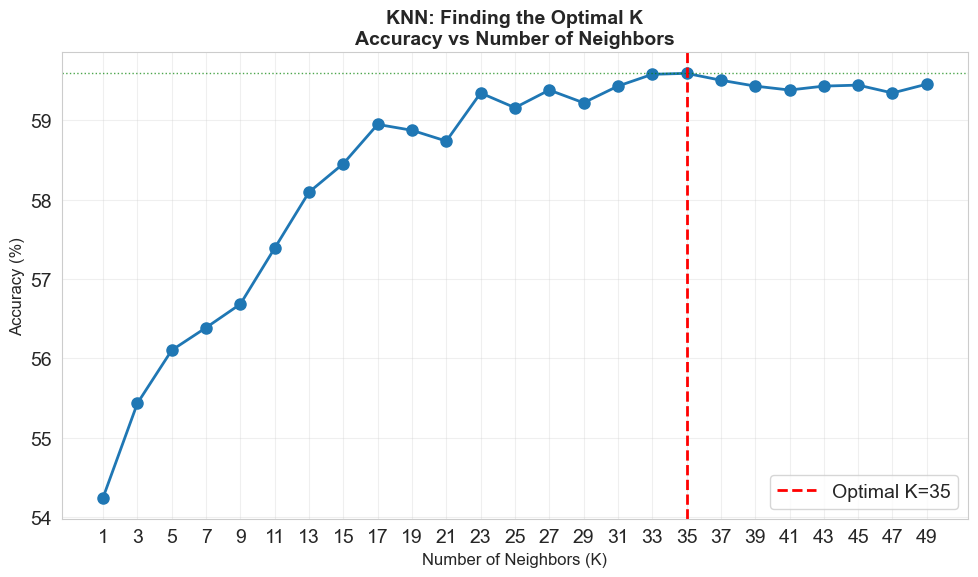


Accuracy for each K:
  K= 1: 54.25%
  K= 3: 55.43%
  K= 5: 56.10%
  K= 7: 56.39%
  K= 9: 56.68%
  K=11: 57.39%
  K=13: 58.09%
  K=15: 58.45%
  K=17: 58.95%
  K=19: 58.87%
  K=21: 58.74%
  K=23: 59.34%
  K=25: 59.16%
  K=27: 59.38%
  K=29: 59.22%
  K=31: 59.43%
  K=33: 59.58%
  K=35: 59.59%  <-- BEST
  K=37: 59.50%
  K=39: 59.43%
  K=41: 59.38%
  K=43: 59.43%
  K=45: 59.44%
  K=47: 59.34%
  K=49: 59.45%


In [44]:
# Test K values from 1 to 40
k_range = range(1, 51, 2)
accuracy_scores = []

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred_temp))

# Find optimal K
optimal_k = k_range[np.argmax(accuracy_scores)]
best_accuracy = max(accuracy_scores)

print(f"Optimal K: {optimal_k}")
print(f"Best Accuracy: {best_accuracy*100:.2f}%")

# Plot K vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_range, [acc*100 for acc in accuracy_scores], marker='o', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')
plt.axhline(y=best_accuracy*100, color='green', linestyle=':', linewidth=1, alpha=0.7)

plt.xlabel('Number of Neighbors (K)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('KNN: Finding the Optimal K\nAccuracy vs Number of Neighbors', fontsize=14, fontweight='bold')
plt.xticks(k_range)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print accuracy for each K
print("\nAccuracy for each K:")
for k, acc in zip(k_range, accuracy_scores):
    marker = "  <-- BEST" if k == optimal_k else ""
    print(f"  K={k:2d}: {acc*100:.2f}%{marker}")

FINAL KNN MODEL (Optimal K=35)

Final Accuracy: 59.59%


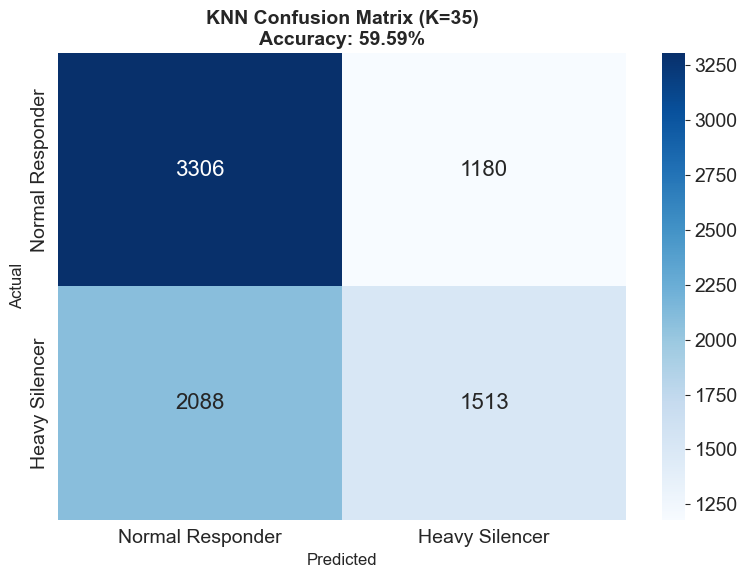


Final Classification Report:
                  precision    recall  f1-score   support

Normal Responder       0.61      0.74      0.67      4486
  Heavy Silencer       0.56      0.42      0.48      3601

        accuracy                           0.60      8087
       macro avg       0.59      0.58      0.58      8087
    weighted avg       0.59      0.60      0.59      8087



In [45]:
# Train final model with *optimal* K
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train_scaled, y_train)
y_pred_final = knn_final.predict(X_test_scaled)

print("="*60)
print(f"FINAL KNN MODEL (Optimal K={optimal_k})")
print("="*60)

# Final Accuracy
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f"\nFinal Accuracy: {accuracy_final*100:.2f}%")

# Final Confusion Matrix
cm_final = confusion_matrix(y_test, y_pred_final)

# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal Responder', 'Heavy Silencer'],
            yticklabels=['Normal Responder', 'Heavy Silencer'],
            annot_kws={'size': 16})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'KNN Confusion Matrix (K={optimal_k})\nAccuracy: {accuracy_final*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final Classification Report
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final, 
                            target_names=['Normal Responder', 'Heavy Silencer']))

The dataset is fairly balanced, with 45% "Heavy Silencers" and 55% "Normal Responders". This means the **baseline accuracy** — achieved by simply predicting the majority class for every observation — is **55%**.

**Model Performance:**
Our KNN classifier (with optimal K=35) achieved an accuracy of **~60%**, outperforming the baseline by approximately 5 percentage points. While this improvement is statistically meaningful, it remains modest.

**What Does This Tell Us?**

1. **Demographics have *some* predictive power:** The fact that the model beats random guessing confirms that demographic features (AGE, EDUCYRS, TOPBOT, WRKHRS, HOMPOP) do contribute to predicting silence behavior. People's age, education, social status, work hours, and household size are weakly associated with their tendency to skip questions.

2. **But demographics are NOT the main driver:** The relatively low accuracy (~60%) aligns perfectly with our earlier findings from **Model A** (OLS regression), which explained only **2% of variance** in silence behavior. Both approaches tell the same story: demographic variables alone cannot reliably identify who will be a "Heavy Silencer."

3. **Unobserved factors dominate:** The moderate performance suggests that the phenomenon of non-response is primarily driven by factors **not captured in the survey**, such as:
   - **Personality traits** (introversion, privacy concerns, social anxiety)
   - **Survey fatigue** (how tired the respondent was)
   - **Topic sensitivity** (as we saw in Model C, silence in one category strongly predicts silence in related categories)
   - **Cultural norms** (as shown in our country-level analysis)

**Comparison with Model C:**
Interestingly, Model C (Logistic Regression using cross-category silence) achieved **79.5% accuracy** — significantly higher than KNN's 60%. This reinforces our key insight: **what predicts silence best is not *who* you are, but *how* you responded to other questions.** Silence is "contagious" across topics, suggesting that personal disposition toward survey non-response matters more than demographic profile.

___

# Final Thoughts: The Sound of Silence

> **"People talking without speaking, People hearing without listening..."**
        
[~ "The Sound of Silence"](https://youtu.be/NAEppFUWLfc?si=t4U5V8SAOa0r_JfE)


We started by looking for 'missing values' in our data, but we ended up finding a deep story about how people connect today.

The famous "The Sound of Silence" song isn't about the quiet we enjoy. It’s about a dangerous silence, the kind that happens when people stop caring or feel like they don't belong. It warns us that when we stop talking to each other, our society starts to break apart.

During the project we tried showed that this silence can happen to anyone. It doesn’t matter if you are rich or poor, young or old, Japanese or Icelandic. Sometimes people stay silent to protect their privacy, but other times, they stay silent because they feel alone.

To truly understand our world, we can't just look at the people who speak the loudest. We must learn to listen to the silence. Behind every statistic, there is a human story. We need to remember that why someone chooses not to speak is just as important as the words they actually say.